In [10]:
import requests 

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd

from time import sleep
import os
import csv
from dotenv import load_dotenv
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()

True

# Guardar resultados en un csv de forma manual

Primero esrcibimos una línea de código que cree un archivo ```.csv``` con el formato que queremos para poder ser utilizada a deseo. En principio, __no la ejecutaremos__.

In [ ]:
'''ESTO BORRA LOS DATOS QUE HAYA EN EL CSV'''

columnas = ['nombre', 'numero de opiniones', 'puntuacion sobre 5', 'ranking', 'precio', 'tipos de cocina', 'dietas especiales', 'ubicaciones', 'puntuaciones desglosadas']
csv_name = 'un_nombre_nuevo.csv'

with open(csv_name, mode='w', newline='', encoding='utf-8') as csvfile: # abro el csv en modo escritura (borra lo que haya)
        writer = csv.writer(csvfile) # creo un objeto writer que permite escribir en el csv
        writer.writerow(columnas) # meto una fila que tenga el nombre de las columnas
        csvfile.close() # cierro el archivo

Ahora, definimos una función que añada datos a un csv. Es importante que esta función así escrita ha de ejecutarse sobre un archivo que ya hayamos creado con las columnas que queremos, porque esta función solo mete datos, pero no le pone los nombres a las columnas. Para crear dicho archivo, podemos ejecutar la línea anterior.

In [1]:
# El mode='a' hace que siga escribiendo si el archivo ya tiene algo dentro, en vez de sobreescribir el archivo

def guardar_csv(data, columnas, csv_name):
    with open(csv_name, mode='a', newline='', encoding='utf-8') as csvfile: # abro el csv en modo append
        writer = csv.writer(csvfile) # creo un objeto writer que permite escribir en el csv
        for i in range(len(data[0])): # creo las filas que tengo que ir metiendo en el csv (hay que ir fila por fila)
            row = [field_list[i] for field_list in data]
            writer.writerow(row)
        csvfile.close() # cierro el archivo

# Guardar la url de la página actual de restaurantes en un .txt por si el código falla 
(Sobreescribe)

In [17]:
def guardar_url_txt(browser, txt_name):
    with open(txt_name, 'w') as txtfile: # abro el txt
        txtfile.write(browser.current_url) # escribo la url actual
        txtfile.close() # cierro el txt

# Sacar la url del archivo .txt

In [18]:
def sacar_url_txt(txt_name): 
    with open(txt_name, 'r') as txtfile: # abro el txt en modo 'r', de lectura
        return txtfile.read() # retorno lo que arroja la lectura (la url)

# WebScrapping a TripAdvisor con Selenium

In [22]:
# Abrimos Chrome con TripAdvisor
browser = webdriver.Chrome()
url = sacar_url_txt('current_url_madrid.txt') # saco la url del txt
browser.get(url)

sleep(2)

# Aceptamos cookies
browser.find_element(by = By.ID, value = 'onetrust-accept-btn-handler').click()

sleep(2)


# Esta lista es auxiliar para conseguir las puntuaciones despues
tipos_rating = ['Pésimo', 'Malo', 'Normal', 'Muy bueno', 'Excelente']
columnas = ['nombre', 'numero de opiniones', 'puntuacion sobre 5', 'ranking', 'precio', 'tipos de cocina', 'dietas especiales', 'ubicaciones', 'puntuaciones desglosadas']


while True:
    # Creamos listas vacias para rellenar y crear el DataFrame
    tipos_cocina = []
    puntuacion_sobre5 = []
    ranking = []
    precios = []
    puntuaciones_desglosadas = []
    num_opiniones = []
    dietas_especiales = []
    ubicaciones = []
    nombres = []
    comidas = []
    ventajas = []

    # Obtenemos la lista de 30 restaurantes que muestra la primera pagina
    sleep(2)
    acceso_restaurantes = browser.find_elements(By.CSS_SELECTOR, '.biGQs._P.fiohW.alXOW.NwcxK.GzNcM.ytVPx.UTQMg.RnEEZ.ngXxk')[15:23]

    # Guardamos la ventana de esta primera pagina para volver despues
    original_window = browser.current_window_handle
    
    # Recorremos los restaurantes y extraemos sus datos
    for rest in acceso_restaurantes:
        sleep(2)
        rest.click()
        
        for window_handle in browser.window_handles:
            if window_handle != original_window:
                browser.switch_to.window(window_handle)
                break
                
        # Sacamos la sopa de la pagina del restaurante
        soup = BeautifulSoup(browser.page_source, 'html.parser')
        
        try:
            puntuacion_sobre5.append(soup.find('span', class_ = 'ZDEqb').text[:3])
        except:
            puntuacion_sobre5.append(np.nan)
            print('falla puntuacion_sobre5')
        try:
            num_opiniones.append(soup.find('a', class_ = 'IcelI').text.split()[0])
        except:
            num_opiniones.append(np.nan)
            print('falla num_opiniones')
        try:
            ubicaciones.append(soup.find('span', class_ = 'yEWoV').text)
        except:
            ubicaciones.append(np.nan)
            print('falla ubicaciones')
        try:
            nombres.append(soup.find('h1', 'HjBfq').text)
        except:
            nombres.append(np.nan)
            print('falla nombres')
        try:
            lista_temp = []
            for idx, tipo_rating in enumerate(tipos_rating):
                lista_temp.append(soup.find('div', {'data-value': f'{idx+1}'}).text.strip(tipo_rating))
            puntuaciones_desglosadas.append(lista_temp)
        except:
            puntuaciones_desglosadas.append(np.nan)
            print('falla puntuaciones_desglosadas')
        
        # Los detalles pueden ser de dos tipos dependiendo de si ofrecen informacion del precio o no.
        detalles = soup.find_all('div', class_ = 'SrqKb')
        if not detalles:
            print('No hay detalles')
            comidas.append(np.nan)
            ventajas.append(np.nan)
            precios.append(np.nan)
            dietas_especiales.append(np.nan)
            tipos_cocina.append(np.nan)
        else:
            if '€' in detalles[0].text:
                try:
                    precios.append(detalles[0].text.split()[::3])
                except:
                    precios.append(np.nan)
                    print('falla precios')
                try:
                    tipos_cocina.append(detalles[1].text.split(','))
                except:
                    tipos_cocina.append(np.nan)
                    print('falla tipos_cocina')
                try:
                    dietas_especiales.append(detalles[2].text.split(','))
                except:
                    dietas_especiales.append(np.nan)
                    print('falla dietas_especiales')     
                comidas.append(np.nan)
                ventajas.append(np.nan)
            else:                 
                try:
                    tipos_cocina.append(detalles[0].text.split(','))
                except:
                    tipos_cocina.append(np.nan)
                    print('falla precios')
                try:
                    comidas.append(detalles[1].text.split(','))
                except:
                    comidas.append(np.nan)
                    print('falla tipos_cocina')
                try:
                    ventajas.append(detalles[2].text.split(','))
                except:
                    ventajas.append(np.nan)
                    print('falla dietas_especiales')     
                precios.append(np.nan)
                dietas_especiales.append(np.nan)
        try:
            ranking.append(soup.find('b').text[1:])
        except:
            ranking.append(np.nan)
            print('falla ranking')

        # cerramos pestaña y volvemos a la ventana original
        sleep(3)
        if browser.current_window_handle != original_window:
            browser.close()
            browser.switch_to.window(original_window)
    
    # Guardamos los datos    
    try:      
        data = [nombres, num_opiniones, puntuacion_sobre5, ranking, precios, tipos_cocina, dietas_especiales, ubicaciones, puntuaciones_desglosadas]
        guardar_csv(data, columnas, 'datos_tripadvisor3.csv')
        guardar_url_txt(browser, 'current_url.txt')
    except:
        print('No se han podido guardar los datos')
        
    # Vamos a la siguiente pagina
    try:
        sleep(3)
        browser.find_element(By.CSS_SELECTOR, '[data-smoke-attr=pagination-next-arrow]').click()
    except:
        print('Hemos acabado')
        break

falla dietas_especiales
falla dietas_especiales
No hay detalles
falla dietas_especiales
falla dietas_especiales
falla tipos_cocina
falla dietas_especiales
No hay detalles
falla dietas_especiales
No hay detalles
falla tipos_cocina
falla dietas_especiales
falla dietas_especiales
falla dietas_especiales
falla dietas_especiales
No hay detalles
falla tipos_cocina
falla dietas_especiales
falla tipos_cocina
falla dietas_especiales
falla dietas_especiales
falla tipos_cocina
falla dietas_especiales
falla dietas_especiales
falla dietas_especiales
falla dietas_especiales
falla dietas_especiales
falla tipos_cocina
falla dietas_especiales
falla tipos_cocina
falla dietas_especiales
falla dietas_especiales
falla dietas_especiales
falla dietas_especiales
falla dietas_especiales
falla tipos_cocina
falla dietas_especiales
falla dietas_especiales
falla dietas_especiales
falla tipos_cocina
falla dietas_especiales
falla dietas_especiales
falla dietas_especiales
falla dietas_especiales
falla tipos_cocina
fa

StaleElementReferenceException: Message: stale element reference: stale element not found
  (Session info: chrome=118.0.5993.118); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#stale-element-reference-exception
Stacktrace:
	GetHandleVerifier [0x00007FF76E328EF2+54786]
	(No symbol) [0x00007FF76E295612]
	(No symbol) [0x00007FF76E14A64B]
	(No symbol) [0x00007FF76E14F116]
	(No symbol) [0x00007FF76E15115F]
	(No symbol) [0x00007FF76E151250]
	(No symbol) [0x00007FF76E18D265]
	(No symbol) [0x00007FF76E182796]
	(No symbol) [0x00007FF76E1ABE6A]
	(No symbol) [0x00007FF76E1822E6]
	(No symbol) [0x00007FF76E1AC080]
	(No symbol) [0x00007FF76E1C4D02]
	(No symbol) [0x00007FF76E1ABC43]
	(No symbol) [0x00007FF76E180941]
	(No symbol) [0x00007FF76E181B84]
	GetHandleVerifier [0x00007FF76E677F52+3524194]
	GetHandleVerifier [0x00007FF76E6CD800+3874576]
	GetHandleVerifier [0x00007FF76E6C5D7F+3843215]
	GetHandleVerifier [0x00007FF76E3C5086+694166]
	(No symbol) [0x00007FF76E2A0A88]
	(No symbol) [0x00007FF76E29CA94]
	(No symbol) [0x00007FF76E29CBC2]
	(No symbol) [0x00007FF76E28CC83]
	BaseThreadInitThunk [0x00007FFC4E797344+20]
	RtlUserThreadStart [0x00007FFC504026B1+33]


# Juntar los datos de los csv y guardarlo como csv

In [144]:
def juntar_csv(lista_archivos, nuevo_nombre):
    with open(nuevo_nombre, 'a', newline='', encoding='utf-8') as csv_nuevo:
        writer = csv.writer(csv_nuevo)
        for csv_file in lista_archivos:
            with open(csv_file[0], 'r', newline = '', encoding='utf-8') as csv_a_juntar:
                reader = csv.reader(csv_a_juntar, delimiter = csv_file[1])
                for row in reader:
                    writer.writerow(row)
                csv_a_juntar.close()

In [145]:
csv_name1 = 'loquequieras.csv'
csv_name2 = 'datos_tripadvisor_Juntos 3.csv'
csv_name3 = 'datos_tripadvisor_alejandro.csv'

lista_archivos = [(csv_name2, ';'), (csv_name3, ',')]
nuevo_nombre = 'datos_tripadvisor_juntos_madrid.csv'
juntar_csv(lista_archivos, nuevo_nombre)

# Pasar el csv a DataFrame y limpiar los datos

In [65]:
df = pd.read_csv('datos_tripadvisor_juntos_madrid.csv')

In [66]:
df = df[df['nombre'] != 'nombre']

In [67]:
df = df.drop_duplicates(keep = 'first')

Tal vez debido a una mala lectura de los datos, hay una novena columna que tiene casi todos sus datos vacíos, pero no todos:

In [68]:
(~df['Unnamed: 9'].isna()).sum()

5

In [69]:
mask_no_nan = ~df['Unnamed: 9'].isna()
df.loc[mask_no_nan]

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,Unnamed: 9
3301,Marta,Cariño!,118,"4,5",1374,"['10', '30']","['Opciones vegetarianas', ' Opciones sin gluten']",['Bebidas'],"Calle Silva 4, 28013 Madrid España","['6', '2', '9', '25', '63']"
3381,La Tagliatella Goya,Madrid,490,"3,5",1704,"['16', '18']","['Italiana', ' Pizza', ' Mediterránea', ' Euro...","['Opciones vegetarianas', ' Opciones veganas',...","Avenida Felipe II 17., 28009 Madrid España","['40', '41', '66', '140', '113']"
3386,17,Burger & Wine,35,5,1708,"['15', '25']","['Española', ' Fusión']","['Cenas', ' Comidas']","C/ Segovia, 17, 28005 Madrid España","['0', '0', '0', '2', '25']"
3765,La Tagliatella C/Orense,Madrid,140,"3,5",3170,"['15', '17']","['Italiana', ' Pizza', ' Europea']",['Opciones vegetarianas'],"Calle Orense 11 28020, 28020 Madrid España","['12', '12', '20', '37', '36']"
3773,La Tagliatella C.C. Plaza Río 2,Madrid,53,4,3218,"['18', '20']","['Italiana', ' Toscana', ' Siciliana', ' Del c...","['Cenas', ' Comidas']","C/ Antonio Lopez 109-111 CC Plaza Río 2, 3ª p...","['8', '2', '5', '8', '27']"


Podemos ver que la columna ```'numero de opiniones'``` tiene datos que corresponderian a parte del nombre y las demas estan desplazadas una columna hacia la derecha.

In [70]:
df.loc[mask_no_nan, 'nombre'] = df.loc[mask_no_nan, 'nombre'] + df.loc[mask_no_nan, 'numero de opiniones']

In [71]:
# Lo mas facil es usar iloc si queremos ir de una columna a la siguiente, pero no admite series como mascara, solo arrays de booleanos

array_mask = mask_no_nan.values
for i in range(1, len(df.columns)-1):
    df.iloc[array_mask, i] = df.iloc[array_mask, i+1]

In [72]:
df[mask_no_nan]

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,Unnamed: 9
3301,Marta Cariño!,118,"4,5",1374,"['10', '30']","['Opciones vegetarianas', ' Opciones sin gluten']",['Bebidas'],"Calle Silva 4, 28013 Madrid España","['6', '2', '9', '25', '63']","['6', '2', '9', '25', '63']"
3381,La Tagliatella Goya Madrid,490,"3,5",1704,"['16', '18']","['Italiana', ' Pizza', ' Mediterránea', ' Euro...","['Opciones vegetarianas', ' Opciones veganas',...","Avenida Felipe II 17., 28009 Madrid España","['40', '41', '66', '140', '113']","['40', '41', '66', '140', '113']"
3386,17 Burger & Wine,35,5,1708,"['15', '25']","['Española', ' Fusión']","['Cenas', ' Comidas']","C/ Segovia, 17, 28005 Madrid España","['0', '0', '0', '2', '25']","['0', '0', '0', '2', '25']"
3765,La Tagliatella C/Orense Madrid,140,"3,5",3170,"['15', '17']","['Italiana', ' Pizza', ' Europea']",['Opciones vegetarianas'],"Calle Orense 11 28020, 28020 Madrid España","['12', '12', '20', '37', '36']","['12', '12', '20', '37', '36']"
3773,La Tagliatella C.C. Plaza Río 2 Madrid,53,4,3218,"['18', '20']","['Italiana', ' Toscana', ' Siciliana', ' Del c...","['Cenas', ' Comidas']","C/ Antonio Lopez 109-111 CC Plaza Río 2, 3ª p...","['8', '2', '5', '8', '27']","['8', '2', '5', '8', '27']"


Ya podemos eliminar la columna ```'Unnamed: 9'```

In [73]:
df = df.reset_index(drop = True).drop('Unnamed: 9', axis=1)

## Número de opiniones

El número de opiniones es un string:

In [74]:
series = df['numero de opiniones']
type(series.iloc[0])

str

Lo pasamos a tipo float (para que coincida con el de los ```np.nan```):

In [75]:
df['numero de opiniones'] = df['numero de opiniones'].astype(float)

In [76]:
df['numero de opiniones'].dtype

dtype('float64')

## Puntuaciones

Ahora, observamos que hay ```np.nan``` en las puntuaciones. No hay un valor lógico de puntuación por los que cambiarlos, así que nos limitamos a cambiar el resto a ```float``` sin modificar estos.

In [77]:
df.loc[df['puntuacion sobre 5'].isna(), 'puntuacion sobre 5']

3379    NaN
4156    NaN
4162    NaN
4348    NaN
4350    NaN
6287    NaN
6295    NaN
6527    NaN
Name: puntuacion sobre 5, dtype: object

In [78]:
mask_no_nan = ~df['puntuacion sobre 5'].isna()
df.loc[mask_no_nan, 'puntuacion sobre 5'] = df.loc[mask_no_nan, 'puntuacion sobre 5'].str.replace(',','.').astype(float)

In [79]:
df['puntuacion sobre 5'] = df['puntuacion sobre 5'].astype(float)

## Ranking

Hacemos lo mismo con la columna ```'ranking'```.

In [80]:
df.loc[df['ranking'].isna(), 'ranking']

2241    NaN
2460    NaN
3379    NaN
6527    NaN
Name: ranking, dtype: object

In [81]:
numeros_str = [f'{i}' for i in range(0,10)]
mask_no_int = ~df.loc[:, 'ranking'].str[0].isin(numeros_str)

df.loc[mask_no_int, 'ranking'].iloc[:10]

38        .º 48
211       .º 75
391      .º 123
676      .º 170
855      .º 206
957     .º 2807
1149     .º 488
1452     .º 318
1468     .º 259
1655      .º 12
Name: ranking, dtype: object

En tiempo de ejecución, es más rápido hacer varias máscaras y editar ```df``` localmente con ```.str```. Sin embargo, el código se hace más largo y menos automatizado, así que preferimos definir una función que edite línea a línea observando el tipo de dato primero.

In [82]:
def convertir_ranking(str_ranking):
    numeros_str = [f'{i}' for i in range(0,10)]
    if str_ranking[0] in numeros_str:
        return float(str_ranking.replace('.',''))
    else:
        return float(str_ranking.split()[1])

In [83]:
mask_no_nan = ~df['ranking'].isna()
df.loc[mask_no_nan, 'ranking'] = df.loc[mask_no_nan, 'ranking'].apply(convertir_ranking)

In [84]:
df['ranking'] = df['ranking'].astype(float)

Es interesante observar que el mismo código no funciona usando ```.loc```. Esto es, probablemente, un bug (lo ha sido en versiones anteriores, según se comenta en la documentación de incidencias de pandas en Github).

```df.loc[:, 'ranking'] = df.loc[:, 'ranking'].astype(float)```

arroja el comportamiento
```

nombre                       object
numero de opiniones         float64
puntuacion sobre 5           object
ranking                      object
precio                       object
tipos de cocina              object
dietas especiales            object
ubicaciones                  object
puntuaciones desglosadas     object
dtype: object
```

Analizando datos del ranking, observamos que hay otro problema: hay varios restaurantes con el mismo ranking

In [85]:
df[df['ranking']==1]

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas
94,Gagos pizza,68.000,4.5,1.0,"['6', '21']","['Pizza', ' Italiana', ' Mediterránea', ' Euro...",['Opciones vegetarianas'],"Avenida Algorta 23, 28830 San Fernando de Hena...","['0', '1', '5', '22', '39']"
1521,Sibuya Urban Sushi Bar X-Madrid,336.000,4.5,1.0,"['4', '30']","['Japonesa', ' Sushi', ' Asiática', ' Saludabl...","['Comidas', ' Cenas', ' Bebidas']","Centro Comercial X Madrid, 28922 Alcorcón España","['11', '6', '10', '23', '284']"
2260,Wakea,77.000,5.0,1.0,NaN,"['Americana', ' Hawaiana']",NaN,"Av. De Europa, 13, 28108 Alcobendas, Madrid Ce...","['0', '1', '0', '4', '72']"
2431,Urrechu,346.000,4.0,1.0,NaN,['Española'],NaN,"C.C. Zoco de Pozuelo, Somosaguas España","['12', '23', '37', '111', '156']"
2453,NaN,388.000,4.0,1.0,NaN,"['Barbacoa', ' Española', ' Argentina', ' Medi...",NaN,"Calle Electrodo 32, 28522 Vaciamadrid España","['12', '25', '57', '116', '172']"
2464,MANDA CARALLO,421.000,4.5,1.0,"['10', '30']","['Española', ' Saludable']",['Opciones sin gluten'],"Carabanchel 14, 28902 Getafe España","['11', '5', '15', '95', '277']"
2471,Los Montes de Galicia,11.363,5.0,1.0,"['50', '90']","['Española', ' Internacional', ' Mediterránea'...","['Opciones veganas', ' Opciones sin gluten']","Calle Azcona 46, 28028 Madrid España","['7', '28', '175', '1.082', '7.395']"
2500,Rigatoni,248.000,4.5,1.0,"['14', '29']","['Italiana', ' Mediterránea', ' Europea', ' Na...","['Opciones vegetarianas', ' Opciones veganas',...","Carretera Boadilla 8, 28220 Majadahonda España","['4', '2', '11', '47', '173']"
2581,Twister Rock&Food Leganés Centro,265.000,4.5,1.0,"['7', '25']",['Americana'],"['Opciones vegetarianas', ' Opciones veganas',...","Calle de San Nicasio, Nº45, 28911 Leganés España","['8', '5', '18', '69', '162']"
4576,Pummarola,602.000,4.5,1.0,"['14', '28']","['Italiana', ' Pizza', ' Mediterránea', ' Euro...","['Opciones vegetarianas', ' Opciones veganas',...","Avenida De Europa, 17 Pozuelo de Alaracón, 282...","['14', '23', '39', '106', '395']"


Esto se debe a que no pertenecen a Madrid ciudad, sino que Trip Advisor ha introducido resultados de la comunidad en nuestra búsqueda en la ciudad de Madrid. Solucionaremos esto filtrando por municipio.

In [86]:
df = df.loc[df['ubicaciones'].str.contains('Madrid España').fillna(False), :]

## Precio

Ahora tenemos que modificar el precio, que damos como una tupla que expresa un rango.

In [87]:
# Esta funcion convierte un str que contiene una lista de str, como "['1', '2', ' 4']", en una lista que contiene a los str sin espacios al inicio o al final: ['1', '2', '4']
def str_list_to_list(str_list):
    lista = str_list.split("'")[1::2]
    lista = [x.strip() for x in lista]
    return lista

In [88]:
# Convertimos a enteros los elementos de una lista
def precio_to_list(str_precio):
    return [int(num) for num in str_list_to_list(str_precio)]

In [89]:
mask_no_nan = ~df['precio'].isna()
            
df.loc[mask_no_nan, 'precio'] = df.loc[mask_no_nan, 'precio'].apply(precio_to_list)

Creamos una columna con el promedio entre los rangos de precio:

In [90]:
df['precio promedio'] = (df['precio'].str[0] + df['precio'].str[1])//2

Podemos también crear columnas que nos indiquen mediante un identificador, ```['alto', 'medio', 'bajo']```, cómo es el precio del restaurante.

In [91]:
def categorizar_precio(promedio):
    if np.isnan(promedio):
        return np.nan
    elif promedio < 25:  
        return 'bajo'
    elif 25 <= promedio < 50:  
        return 'medio'
    else:
        return 'alto'

In [92]:
df['categoria precio'] = df['precio promedio'].apply(categorizar_precio)

## Tipos de cocina

Para estudiar los distintos tipos de cocina, podemos verlos como conjuntos. Por ejemplo, es claro que en casi todos los restaurantes que tengan cocina ```'Pizza'``` tendrán cocina ```'Italiana'```.

In [93]:
mask_italiana = df['tipos de cocina'].str.contains('Italiana')
mask_no_nan = ~df.loc[:, 'tipos de cocina'].isna()
set_italiana = set(df.loc[mask_no_nan&mask_italiana, 'tipos de cocina'].index)

In [94]:
mask_pizza = df['tipos de cocina'].str.contains('Pizza')
mask_no_nan = ~df.loc[:, 'tipos de cocina'].isna()
set_pizza = set(df.loc[mask_no_nan&mask_pizza, 'tipos de cocina'].index)

In [95]:
print(f'Numero de restaurantes con tipo de comida Italiana: {len(set_italiana)}')
print(f'Numero de restaurantes con tipo de comida Pizza: {len(set_pizza)}')
print(f'Numero de restaurantes con tipo de comida Pizza y no italiana: {len(set_pizza - set_italiana)}')
print(f'Numero de restaurantes con tipo de comida Italiana y no Pizza: {len(set_italiana - set_pizza)}')

Numero de restaurantes con tipo de comida Italiana: 405
Numero de restaurantes con tipo de comida Pizza: 253
Numero de restaurantes con tipo de comida Pizza y no italiana: 50
Numero de restaurantes con tipo de comida Italiana y no Pizza: 202


Podemos, de hecho, ver sus nombres:

In [96]:
pizza_no_italiana = list(set_pizza - set_italiana)
df.loc[pizza_no_italiana, 'nombre']

4481                      Pizza Mirasierra
6788                    Cor&Cor  PeÃ±alver
1416                          Tasty Market
3464                                Ene 50
3210                         Tortuga Pizza
6795          Domino's Pizza Santa Barbara
657                                  Oguis
5524                                 Oguis
4505                     Pizza Hut Francos
6171               El Refugio de Vinateros
1437            Chicago Style Pizza Maudes
6180                          Tasty Market
1188               Cobata Salvatelli Pizza
4516                             Doshornos
6567                              Lomirock
5803                         Samber Atocha
3372                  Mi Taberna el Pirata
4142                         Muzza & Faina
6446                               Tinglao
6195            Chicago Style Pizza Maudes
2227                Mad Gourmets Canalejas
6843                             Telepizza
3646             Hibou Shishas & Cocktails
4545       

Para hacernos una idea de los tipos de cocina distintos, visualizamos un conjunto con cada palabra distinta que aparece como tipo de cocina. Recogeremos algunas como categorías generales y catalogaremos todas según la categoría a la que pertenezcan

In [97]:
mask_no_nan = ~df['tipos de cocina'].isna()
series_no_nan = df.loc[mask_no_nan, 'tipos de cocina']

l = []
for str_list in series_no_nan.unique():
    l.extend(str_list.split("'")[1::2])
    
l = [x.strip() for x in l]
print(set(l))

{'Kaiseki', 'Singapureña', 'Marroquí', 'Australiana', 'Comidas', 'Fruterías', 'Árabe', 'Indonesia', 'Bares para comer', 'Barbacoa', 'Colombiana', 'Británica', 'Restaurante de carne', 'Mediterránea', 'Acceso para discapacitados', 'Española', 'Cajún y criolla', 'Del Lacio', 'India americana', 'Jamaicana', 'Opciones vegetarianas', 'Libanesa', 'Napolitana', 'Capacidad', 'Contemporánea', 'Desayuno', 'Abierto hasta tarde', 'Hawaiana', 'Reservas', 'Confitería japonesa', 'Persa', 'Del sur de Italia', 'Turca', 'Comida rápida', 'Suiza', 'Asiática', 'Cubana', 'Del norte de Italia', 'Del centro de Italia', 'Restaurantes de cerveza', 'Tienda gourmet', 'Argentina', 'Rusa', 'Sirve alcohol', 'Portuguesa', 'Tailandesa', 'Opciones sin gluten', 'Tibetana', 'Romana', 'Pub restaurante', 'Saludable', 'Brunch', 'De Europa oriental', 'Griega', 'Admite perros', 'Latina', 'Siciliana', 'Opciones veganas', 'China', 'Ecuatoriana', 'Sueca', 'Café', 'Pub', 'Apuliana', 'Albanesa', 'Comedor', 'Caribeña', 'Alemana', 'C

Ahora, limpiamos los datos de tipos de cocina para convertirlos en listas.

In [98]:
mask_no_nan = ~df['tipos de cocina'].isna()

df.loc[mask_no_nan, 'tipos de cocina'] = df.loc[mask_no_nan, 'tipos de cocina'].apply(str_list_to_list)

Emparejamos cada tipo de cocina con una de las categorías globales (```categorias_cocina.keys()```) que vamos a utilizar para clasificar, de tal forma que cada tipo de cocina solo corresponda a una categoría global. Después, clasificamos y creamos una columna por categoría.

In [99]:
categorias_cocina = {
    'tipos cocina española': ['Española','Marisco'],
    'tipos cocina italiana': ['Apuliana', 'Del Lacio', 'Sarda','Lombarda','De Campania', 'Toscana', 'Romana', 'Siciliana', 'Del norte de Italia', 'Del sur de Italia', 'Del centro de Italia', 'Napolitana','Italiana', 'Pizza'],
    'tipos cocina francesa': ['Francesa'],
    'tipos cocina europea': ['Griega', 'Albanesa',  'Irlandesa', 'De Europa oriental','Rusa', 'Mediterránea','Británica', 'Sueca', 'Húngara','Europea', 'Catalana', 'Centroeuropea', 'Belga', 'Suiza', 'Portuguesa', 'Holandesa', 'Rumana', 'Polaca', 'Alemana'],
    'tipos cocina asiatica sur': ['Singapureña','Bangladeshi', 'Balti', 'India', 'Indonesia', 'Vietnamita', 'Nepalí', 'Indonesia', 'Tailandesa', 'Filipina', 'Malaya', 'Taiwanesa'],
    'tipos cocina asiatica este': ['Coreana','Sushi', 'Cocina de Kioto','Polinesia','De Asia central', 'Cocina de Pekín', 'Confitería japonesa', 'Koreana', 'Fusión japonesa', 'China', 'Coreana',  'Fujian', 'Yunnan', 'Asiática', 'Tibetana', 'Japonesa', 'Kaiseki'],    
    'tipos cocina norteamericana': ['India americana', 'Hawaiana','Americana', 'Cajún y criolla', 'India americana', 'Comida rápida', 'Street food / Comida en la calle'],
    'tipos cocina latinoamerica': ['Brasileña','Mexicana', 'Sudamericana', 'Colombiana', 'Venezolana', 'Chilena', 'Argentina', 'Jamaicana', 'Ecuatoriana', 'Cubana', 'Latina', 'Centroamericana', 'Caribeña', 'Peruana'],
    'tipos cocina africana': ['Etíope', 'Africana', 'Marroquí'],
    'tipos cocina arabe': ['Azerbayana','Marroquí','Persa', 'De Oriente Medio', 'Israelí','Pakistaní', 'Árabe', 'Libanesa', 'Afgana', 'Armenia', 'Turca', 'Egipcia', 'Georgiana']
}


def limpieza_tipo_cocina(tipos, categoria):
    if isinstance(tipos, list):
        return any(tipo in categorias_cocina[categoria] for tipo in tipos)
    return False

for categoria in categorias_cocina.keys():
    df[categoria] = df['tipos de cocina'].apply(limpieza_tipo_cocina, args=(categoria,))

In [100]:
df.head()

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,precio promedio,...,tipos cocina española,tipos cocina italiana,tipos cocina francesa,tipos cocina europea,tipos cocina asiatica sur,tipos cocina asiatica este,tipos cocina norteamericana,tipos cocina latinoamerica,tipos cocina africana,tipos cocina arabe
0,Alduccio,215.0,4.0,1298.0,NaN,"[Italiana, Pizza, Mediterránea, Europea]",NaN,"Avenida Concha Espina 8, 28036 Madrid España","['10', '22', '23', '49', '86']",NaN,...,False,True,False,True,False,False,False,False,False,False
1,Viva Chapata,184.0,4.0,1299.0,NaN,"[Bar, Mediterránea, Europea, Española, Saludab...",NaN,"Calle del Ave María 43, 28012 Madrid España","['11', '2', '16', '67', '70']",NaN,...,True,False,False,True,False,False,False,False,False,False
2,Vinateros 28,184.0,4.0,1300.0,NaN,"[Mediterránea, Española, Contemporánea]",NaN,"Camino Vinateros 28, 28030 Madrid España","['8', '9', '24', '56', '87']",NaN,...,True,False,False,True,False,False,False,False,False,False
3,Thai Arturo Soria,994.0,3.5,1159.0,"[30, 40]","[Asiática, Tailandesa, Internacional, Saludabl...","['Opciones vegetarianas', ' Opciones veganas',...","calle arturo soria 205, 28033 Madrid España","['63', '78', '199', '316', '269']",35.0,...,False,False,False,False,True,True,True,False,False,False
5,Sagardi Castellana,313.0,4.0,1301.0,"[30, 60]","[Restaurante de carne, Española, Asador, Conte...","['Comidas', ' Cenas', ' Abierto hasta tarde', ...","Paseo de la Castellana, 13, 28046 Madrid España","['19', '27', '31', '65', '76']",45.0,...,True,False,False,False,False,False,False,False,False,False


## Dietas especiales

Ahora vamos a hacer lo mismo con los tipos de dietas especiales:

In [101]:
mask_no_nan = ~df['dietas especiales'].isna()
series_no_nan = df.loc[mask_no_nan, 'dietas especiales']

l = []
for str_list in series_no_nan.unique():
    l.extend(str_list.split("'")[1::2])
    
l = [x.strip() for x in l]
print(set(l))

{'Música en directo', 'Abierto hasta tarde', 'Tarjetas de regalo disponibles', 'Restaurantes de no fumadores', 'Reservas', 'Pagos digitales', 'Acepta Visa', 'Vino y cerveza', 'Comidas', 'Aparcacoches', 'Halal', 'Bar completo', 'Sirve alcohol', 'Cenas', 'Opciones sin gluten', 'Admite perros', 'Brunch', 'Acceso para discapacitados', 'Acepta Mastercard', 'Opciones veganas', 'Wifi gratuito', 'Para llevar', 'Televisión', 'Acepta American Express', 'Kosher', 'Opciones vegetarianas', 'Bebidas', 'Servicio de mesa', 'Capacidad', 'Solo efectivo', 'Estilo familiar', 'A domicilio', 'Acepta tarjetas de crédito', 'Terraza exterior', 'Desayuno', 'Aparcamiento en la calle'}


Convertimos los tipos de cocina en columnas y ponemos ```False``` o ```True``` según los tengan o no cada restaurante. Como para cada tipo de dieta especial solo hay que verificar una palabra, no hace falta hacer un diccionario como antes. Podemos simplemente evaluar si esa palabra está en nuestro dato cuando todavía es un ```str```. Después, convertimos los datos a listas.

In [102]:
mask_no_nan = ~df['dietas especiales'].isna()
dietas_especiales = ['Halal', 'Kosher', 'Opciones sin gluten', 'Opciones veganas', 'Opciones vegetarianas']
df[dietas_especiales] = False

for dieta in dietas_especiales:
    df.loc[mask_no_nan, dieta] = df.loc[mask_no_nan, 'dietas especiales'].str.contains(dieta)

In [103]:
df.head()

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,precio promedio,...,tipos cocina asiatica este,tipos cocina norteamericana,tipos cocina latinoamerica,tipos cocina africana,tipos cocina arabe,Halal,Kosher,Opciones sin gluten,Opciones veganas,Opciones vegetarianas
0,Alduccio,215.0,4.0,1298.0,NaN,"[Italiana, Pizza, Mediterránea, Europea]",NaN,"Avenida Concha Espina 8, 28036 Madrid España","['10', '22', '23', '49', '86']",NaN,...,False,False,False,False,False,False,False,False,False,False
1,Viva Chapata,184.0,4.0,1299.0,NaN,"[Bar, Mediterránea, Europea, Española, Saludab...",NaN,"Calle del Ave María 43, 28012 Madrid España","['11', '2', '16', '67', '70']",NaN,...,False,False,False,False,False,False,False,False,False,False
2,Vinateros 28,184.0,4.0,1300.0,NaN,"[Mediterránea, Española, Contemporánea]",NaN,"Camino Vinateros 28, 28030 Madrid España","['8', '9', '24', '56', '87']",NaN,...,False,False,False,False,False,False,False,False,False,False
3,Thai Arturo Soria,994.0,3.5,1159.0,"[30, 40]","[Asiática, Tailandesa, Internacional, Saludabl...","['Opciones vegetarianas', ' Opciones veganas',...","calle arturo soria 205, 28033 Madrid España","['63', '78', '199', '316', '269']",35.0,...,True,True,False,False,False,False,False,True,True,True
5,Sagardi Castellana,313.0,4.0,1301.0,"[30, 60]","[Restaurante de carne, Española, Asador, Conte...","['Comidas', ' Cenas', ' Abierto hasta tarde', ...","Paseo de la Castellana, 13, 28046 Madrid España","['19', '27', '31', '65', '76']",45.0,...,False,False,False,False,False,False,False,False,False,False


In [104]:
categorias_cocina.keys()

dict_keys(['tipos cocina española', 'tipos cocina italiana', 'tipos cocina francesa', 'tipos cocina europea', 'tipos cocina asiatica sur', 'tipos cocina asiatica este', 'tipos cocina norteamericana', 'tipos cocina latinoamerica', 'tipos cocina africana', 'tipos cocina arabe'])

También podemos limpiar los datos de dietas especiales:

In [105]:
mask_no_nan = ~df['dietas especiales'].isna()

def str_list_to_list(str_list):
    lista = str_list.split("'")[1::2]
    lista = [x.strip() for x in lista]
    return lista

df.loc[mask_no_nan, 'dietas especiales'] = df.loc[mask_no_nan, 'dietas especiales'].apply(str_list_to_list)

## Puntuaciones desglosadas

Primero pasamos de ```string``` a una lista:

In [106]:
mask_no_nan = ~df['puntuaciones desglosadas'].isna()

def str_list_to_list(str_list):
    lista = str_list.split("'")[1::2]
    lista = [x.strip() for x in lista]
    return lista

df.loc[mask_no_nan, 'puntuaciones desglosadas'] = df.loc[mask_no_nan, 'puntuaciones desglosadas'].str.replace('.','').apply(str_list_to_list)

Ahora creamos una columna para cada puntuación de opiniones: ```['Pésimo', 'Malo', 'Normal', 'Muy bueno', 'Excelente']```.

In [107]:
puntuaciones = ['Pésimo', 'Malo', 'Normal', 'Muy bueno', 'Excelente']

for idx, puntuacion in enumerate(puntuaciones):
    df[puntuacion] = df['puntuaciones desglosadas'].str[idx].astype(float)

## Ajuste del número de opiniones

In [108]:
df['numero de opiniones'] = df[puntuaciones].sum(axis=1)

## Datos incorrectos en las ubicaciones

In [109]:
df = pd.read_csv('datos_tripadvisor_juntos_madrid_limpio.csv')

In [110]:
numeros_str = [f'{i}' for i in range(0,10)]
mask = df['ubicaciones'].str.split(',').str[0].str.startswith(tuple(numeros_str))
df.loc[mask, :].head(3)

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,precio promedio,...,Halal,Kosher,Opciones sin gluten,Opciones veganas,Opciones vegetarianas,Pésimo,Malo,Normal,Muy bueno,Excelente
77,Najera,217.0,4.0,1584.0,"[15, 35]","['Mediterránea', 'Española']","['Comidas', 'Cenas', 'Abierto hasta tarde']","28015, 28015 Madrid España","['13', '5', '23', '73', '103']",25.0,...,False,False,False,False,False,13.0,5.0,23.0,73.0,103.0
197,Kaldea,14.0,5.0,2100.0,NaN,"['Española', 'Comedor', 'Mediterránea']",NaN,"4 Calle De Castelló, Madrid España","['0', '0', '0', '2', '12']",NaN,...,False,False,False,False,False,0.0,0.0,0.0,2.0,12.0
240,Bandida,13.0,5.0,2258.0,NaN,['Española'],NaN,"8 Calle De La Cruz, 28012 Madrid España","['0', '0', '0', '0', '13']",NaN,...,False,False,False,False,False,0.0,0.0,0.0,0.0,13.0


En las primeras filas ya se ve el problema: hay algunas ubicaciones en las que el número aparece delante del nombre de la calle, y otras en las que no hay nombre de la calle. Dejamos las segundas, porque podremos corregir la dirección al pasarla a la API de Google Maps Platform, y borramos las segundas.

In [111]:
cp = set(str(x) for x in range(28000, 30000))
mask_cp = df['ubicaciones'].str.split(',').str[0].isin(cp)
indices = df.loc[mask_cp, :].index

In [112]:
df = df.drop(indices)

## Lo guardamos como csv limpio de duplicados. Estos son todos los datos hasta el momento

In [113]:
df.head()

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,precio promedio,...,Halal,Kosher,Opciones sin gluten,Opciones veganas,Opciones vegetarianas,Pésimo,Malo,Normal,Muy bueno,Excelente
0,Alduccio,190.0,4.0,1298.0,NaN,"['Italiana', 'Pizza', 'Mediterránea', 'Europea']",NaN,"Avenida Concha Espina 8, 28036 Madrid España","['10', '22', '23', '49', '86']",NaN,...,False,False,False,False,False,10.0,22.0,23.0,49.0,86.0
1,Viva Chapata,166.0,4.0,1299.0,NaN,"['Bar', 'Mediterránea', 'Europea', 'Española',...",NaN,"Calle del Ave María 43, 28012 Madrid España","['11', '2', '16', '67', '70']",NaN,...,False,False,False,False,False,11.0,2.0,16.0,67.0,70.0
2,Vinateros 28,184.0,4.0,1300.0,NaN,"['Mediterránea', 'Española', 'Contemporánea']",NaN,"Camino Vinateros 28, 28030 Madrid España","['8', '9', '24', '56', '87']",NaN,...,False,False,False,False,False,8.0,9.0,24.0,56.0,87.0
3,Thai Arturo Soria,925.0,3.5,1159.0,"[30, 40]","['Asiática', 'Tailandesa', 'Internacional', 'S...","['Opciones vegetarianas', 'Opciones veganas', ...","calle arturo soria 205, 28033 Madrid España","['63', '78', '199', '316', '269']",35.0,...,False,False,True,True,True,63.0,78.0,199.0,316.0,269.0
4,Sagardi Castellana,218.0,4.0,1301.0,"[30, 60]","['Restaurante de carne', 'Española', 'Asador',...","['Comidas', 'Cenas', 'Abierto hasta tarde', 'B...","Paseo de la Castellana, 13, 28046 Madrid España","['19', '27', '31', '65', '76']",45.0,...,False,False,False,False,False,19.0,27.0,31.0,65.0,76.0


In [114]:
df = df.drop_duplicates(keep = 'first').reset_index(drop=True)

In [115]:
df.to_csv('datos_tripadvisor_juntos_madrid_limpio.csv', index = False)

In [116]:
df = pd.read_csv('datos_tripadvisor_juntos_madrid_limpio.csv')

# Pasando direcciones a coordenadas con Google Geocoding API

Hacemos una petición para ver que los datos vienen presentados en el siguiente formato:

In [82]:
API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')
BASE_URL = 'https://maps.googleapis.com/maps/api/geocode/json'
params = {'address': 'Avda Europa 93 La Hacienda De Machado, 36212 Vigo España',
              'key': API_KEY}
respuesta = requests.get(BASE_URL, params=params)
datos = respuesta.json()
pprint(datos)

{'results': [{'address_components': [{'long_name': '93',
                                      'short_name': '93',
                                      'types': ['street_number']},
                                     {'long_name': 'Avenida Europa',
                                      'short_name': 'Av. Europa',
                                      'types': ['route']},
                                     {'long_name': 'Vigo',
                                      'short_name': 'Vigo',
                                      'types': ['locality', 'political']},
                                     {'long_name': 'Pontevedra',
                                      'short_name': 'PO',
                                      'types': ['administrative_area_level_2',
                                                'political']},
                                     {'long_name': 'Galicia',
                                      'short_name': 'GA',
                                      'types'

Esta función hace una request a la API de Geocoding de Google Maps Platform y nos devuelve todo tipo de datos sobre la dirección proporcionada.

In [32]:
def obtener_geodata(direccion):
    API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')
    BASE_URL = 'https://maps.googleapis.com/maps/api/geocode/json'
    params = {
        'address': direccion,
        'key': API_KEY}
    response = requests.get(BASE_URL, params=params)
    datos = response.json()
    if datos['status'] == 'OK':
        try:
            ubicacion = datos['results'][0]['geometry']['location']
            latitud = ubicacion['lat']
            longitud = ubicacion['lng']
            direccion_completa = datos['results'][0]['formatted_address']
            municipio = datos['results'][0]['address_components'][2]['long_name']
            provincia = datos['results'][0]['address_components'][3]['long_name']
            codigo_postal = datos['results'][0]['address_components'][-1]['long_name']
        except:
            print('falla')
            ubicacion = np.nan
            latitud = np.nan
            longitud = np.nan
            direccion_completa = np.nan
            municipio = np.nan
            provincia = np.nan
            codigo_postal = np.nan
        
        return [latitud, longitud, municipio, provincia, codigo_postal, direccion_completa, datos]
    else:
        print('Error:', datos['status'])
        return [np.nan, np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan]

In [45]:
def guardar_csv_geo(data, csv_name):
    with open(csv_name, mode='a', newline='', encoding='utf-8') as csvfile: # abro el csv en modo append
        writer = csv.writer(csvfile) # creo un objeto writer que permite escribir en el csv
        writer.writerow(data)
        csvfile.close() # cierro el archivo

Creamos un archivo nuevo para contener los datos usando la función anterior:

In [44]:
geo_data = ['lat', 'long', 'municipio', 'provincia', 'codigo postal', 'direccion completa corregida', 'datos completos']
csv_name = 'datos_madrid_geodata_completo.csv'

guardar_csv_geo(geo_data, csv_name)

Ejecutamos un bucle que tome la ubicación en cada fila, haga una petición a la API y nos devuelva los datos para guardarlos en el csv.

In [ ]:
for idx, row in df.iterrows():
    data = obtener_geodata(row['ubicaciones'])
    guardar_csv_geo(data, 'datos_madrid_geodata_completo.csv')

Ahora juntamos ambos ```DataFrame``` en uno:

In [136]:
df2 = pd.read_csv('datos_madrid_geodata_completo.csv')

In [137]:
df2 = df2.drop([0,1]).reset_index(drop=True)

In [119]:
df2 = df2.drop_duplicates(keep = 'first').reset_index(drop=True)

In [138]:
df.shape

(4974, 31)

In [139]:
df2.shape

(4974, 7)

In [278]:
geo_data = ['lat', 'long', 'municipio', 'provincia', 'codigo postal', 'direccion completa corregida', 'datos completos']

df[geo_data] = df2

In [142]:
df.to_csv('datos_tripadvisor_madrid_limpio.csv', index = False)

In [134]:
df = pd.read_csv('datos_tripadvisor_juntos_madrid_limpio1.csv')
df = df.drop_duplicates(keep='first').reset_index(drop=True)

In [135]:
df.shape

(4974, 31)

## Limpiamos los datos de los que no hemos podido obtener una ubicación correcta

In [143]:
df = pd.read_csv('datos_tripadvisor_madrid_limpio.csv')

In [148]:
df['direccion completa corregida'].dropna().str.split().str[0].str.contains('28')

19

In [149]:
mask = df['direccion completa corregida'].dropna().str.split().str[0].str.contains('28')
indices = df.loc[mask, :].index
dfm.loc[indices, :]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [108]:
dfm = dfm.drop(indices)

Veamos los tipos de vías que aparecen en estas ubicaciones:

In [200]:
dfm['direccion completa corregida'].str.split(',').str[0].str.split().str[0].unique()

array(['C.', 'Av.', 'Pl.', 'P.º', 'Calle', 'Av', 'Tr.ª', 'C/', 'Paseo',
       'Cost.ª', 'Carrera', 'Cra', 'Gta.', 'Cl.', 'Plaza', 'Ctra.',
       'Edificio', 'Cuesta', 'Ronda', 'Rda.', 'Pje.', 'Cta.', 'Cmo',
       'A-6', 'Centro', 'Blvr.', 'O2', 'Glorieta', 'Marqués',
       'Costanilla', 'Carr.', 'Cam.', 'Estación'], dtype=object)

In [125]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('C.G')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

44         C.Gran Vía, 21, 28013 Madrid, Spain
60         C.Gran Vía, 84, 28013 Madrid, Spain
478    C.Gran Vía, 84, 27, 28013 Madrid, Spain
810        C.Gran Vía, 40, 28013 Madrid, Spain
843        C.Gran Vía, 58, 28013 Madrid, Spain
970                  C.Gran Vía, Madrid, Spain
Name: direccion completa corregida, dtype: object

Algunas ubicaciones en Gran Vía están mal formateadas y necesitan un espacio entre ```C.``` y ```Gran```.

In [130]:
dfm.loc[mask, 'direccion completa corregida'] =  dfm.loc[mask, 'direccion completa corregida'].str.replace('C.Gran', 'C. Gran')

Algunas ubicaciones están en metros cuando no deberían, lo cual es fallo de Google Maps Platform. En estos casos (y como son pocas), las tenemos que borrar para que no interfieran después.

In [136]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Metro')
indices = dfm.loc[mask, 'direccion completa corregida'].index
dfm = dfm.drop(indices)

Algunas ubicaciones solo contienen la ciudad y el país, así que las borramos

In [139]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Madrid')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

319    Madrid, Spain
391    Madrid, Spain
684    Madrid, Spain
686    Madrid, Spain
Name: direccion completa corregida, dtype: object

In [141]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Madrid')
indices = dfm.loc[mask, 'direccion completa corregida'].index
dfm = dfm.drop(indices)

In [142]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Comercial')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

62    Comercial El Corte Inglés, Pl. del Callao, 2, ...
Name: direccion completa corregida, dtype: object

Aquí maps también ha obtenido mal la dirección, así que borramos el restaurante.

In [144]:
indices = dfm.loc[mask, 'direccion completa corregida'].index
dfm = dfm.drop(indices)

In [148]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Palas')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
101,"C/ Palas Del Rey, N 38 Las Tablas, 28050 Madri...","Palas De Rey, 28050 Madrid, Spain"


In [149]:
dfm.loc[mask, 'direccion completa corregida'] =  dfm.loc[mask, 'direccion completa corregida'].str.replace('Palas', 'C. Palas')

In [150]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Corre.')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
114,"Corredera Alta de San Pablo, 13 28004, 28004 M...","Corre. Alta de San Pablo, 13, 28004 Madrid, Spain"
204,"Calle De La Corredera Baja De San Pablo 25, 28...","Corre. Baja de San Pablo, 25, 28004 Madrid, Spain"
499,"Corredera Alta de San Pablo 11, 28004 Madrid E...","Corre. Alta de San Pablo, 11, 28004 Madrid, Spain"
788,"Corredera Baja De San Pablo, 41 Madrid, 28004 ...","Corre. Baja de San Pablo, 41, 28004 Madrid, Spain"


En este caso, en realidad, está obviando el tipo de vía, así que la añadimos manualmente:

In [156]:
dfm.loc[mask, 'direccion completa corregida'] =  dfm.loc[mask, 'direccion completa corregida'].str.replace('Corre.', 'C. Corre.')

In [158]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Cava')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
90,"Calle Cava de San Miguel 4, 28005 Madrid España","Cava de San Miguel, 4, 28005 Madrid, Spain"
270,"Cava de San Miguel 3, 28005 Madrid España","Cava de San Miguel, 3, 28005 Madrid, Spain"


En este caso, en realidad, está obviando el tipo de vía, así que la añadimos manualmente:

In [166]:
dfm.loc[mask, 'direccion completa corregida'] =  dfm.loc[mask, 'direccion completa corregida'].str.replace('Cava', 'C. Cava')

In [170]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Vicálvaro')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
277,"13,Vicalvaro, Calle Condesa Vega del Pozo 2803...","Vicálvaro, 28032 Madrid, Spain"


In [171]:
indices = dfm.loc[mask, 'direccion completa corregida'].index
dfm = dfm.drop(indices)

In [172]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Santa')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
383,Calle Zurbano 83 esquina a Bretón de los Herre...,"Santa Engracia - Bretón De Los Herreros, 28003..."


In [173]:
indices = dfm.loc[mask, 'direccion completa corregida'].index
dfm = dfm.drop(indices)

In [183]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Mercado')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
409,"Calle de Alonso Cano 10 Local 6, 28010 Madrid ...","Mercado de Chamberí, C. de Alonso Cano, 10, lo..."


Este caso es importante: la dirección está bien, pero no empieza por el tipo de vía.

In [195]:
dfm.loc[mask, 'direccion completa corregida'] = dfm.loc[mask, 'direccion completa corregida'].str.partition(',', expand=False).str[2]

In [196]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Cinco')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
676,"Torre Emperador Castellana, P.º de la Castella...","Cinco Torres Business Area, P.º de la Castella..."


In [197]:
dfm.loc[mask, 'direccion completa corregida'] =  dfm.loc[mask, 'direccion completa corregida'].str.partition(',', expand=False).str[2]

In [198]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Torre')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
734,Paseo de la Castellana 259 Local L-304B – Torr...,"Torre PwC, P.º de la Castellana, 259, Local L-..."


In [199]:
dfm.loc[mask, 'direccion completa corregida'] =  dfm.loc[mask, 'direccion completa corregida'].str.partition(',', expand=False).str[2]

In [202]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('A-6')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
700,"Marques De Riscal 6, 28010 Madrid España","A-6, Madrid, Spain"


In [203]:
indices = dfm.loc[mask, 'direccion completa corregida'].index
dfm = dfm.drop(indices)

In [204]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Centro')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
739,"Avenida Río Guadalquivir, 13 C.C. Nassica C.C....","Centro Comercial Nassica, Av. Río Guadalquivir..."


In [206]:
dfm.loc[mask, 'direccion completa corregida'] =  dfm.loc[mask, 'direccion completa corregida'].str.partition(',', expand=False).str[2]

In [207]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('O2')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
789,"Avenida de la Victoria 2, 28023 Madrid España","O2 Centro, Av. de la Victoria, 2, 28023 Madrid..."


In [208]:
dfm.loc[mask, 'direccion completa corregida'] =  dfm.loc[mask, 'direccion completa corregida'].str.partition(',', expand=False).str[2]

In [209]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Marqués')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
827,Paseo del Marques de Zafra 33 Con vuelta a Azu...,"Marqués De Zafra, 28028 Madrid, Spain"


In [210]:
indices = dfm.loc[mask, 'direccion completa corregida'].index
dfm = dfm.drop(indices)

In [213]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Estación')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
943,Calle Padilla 63 a pocos metros de la estacion...,"Estación de Diego de León, 28028 Madrid, Spain"


In [214]:
indices = dfm.loc[mask, 'direccion completa corregida'].index
dfm = dfm.drop(indices)

In [216]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str[0].str.split().str[0].str.contains('Edificio')
dfm.loc[mask, ['ubicaciones', 'direccion completa corregida']]

,ubicaciones,direccion completa corregida
214,"Calle de Rafael Calvo 38, 28010 Madrid España","Edificio escultor, C. de Rafael Calvo, 38, 280..."


In [217]:
dfm.loc[mask, 'direccion completa corregida'] =  dfm.loc[mask, 'direccion completa corregida'].str.partition(',', expand=False).str[2]

Corregimos las direcciones sin número filtrando por el número de datos que tiene la dirección.

In [386]:
mask = dfm.loc[:, 'direccion completa corregida'].str.split(',').str.len() > 3
dfm = dfm.loc[mask, :]

In [387]:
dfm['direccion completa corregida'].str.split(',').str[0].str.split().str[0].unique()

array(['C.', 'Av.', 'Pl.', 'P.º', 'Calle', 'Av', 'Tr.ª', 'C/', 'Paseo',
       'Cost.ª', 'Carrera', 'Cra', 'Gta.', 'Cl.', 'Plaza', 'Ctra.',
       'Cuesta', 'Ronda', 'Rda.', 'Pje.', 'Cta.', 'Cmo', 'Blvr.',
       'Glorieta', 'Costanilla', 'Carr.', 'Cam.'], dtype=object)

In [469]:
dfm.loc[:,'direccion completa corregida'] = dfm.loc[:, 'direccion completa corregida'].str.replace('Dr.', 'Doctor')

In [479]:
tildes = ['á', 'é', 'í', 'ó', 'ú']
sin_tildes = ['a', 'e', 'i', 'o', 'u']

for con_tilde, sin_tilde in zip(tildes, sin_tildes):
    dfm.loc[:,'direccion completa corregida'] = dfm.loc[:, 'direccion completa corregida'].str.replace(con_tilde, sin_tilde)

In [485]:
tildes = ['á', 'é', 'í', 'ó', 'ú']
sin_tildes = ['a', 'e', 'i', 'o', 'u']

for con_tilde, sin_tilde in zip(tildes, sin_tildes):
    dfm.loc[:,'direccion completa corregida'] = dfm.loc[:, 'direccion completa corregida'].str.replace(con_tilde.upper(), sin_tilde.upper())

## Creamos una columna con el distrito y el barrio para los restaurantes de Madrid

Al parecer, el mismo código postal puede pertener a varios barrios, así que no podemos usarlos directamente para determinar el nombre del barrio.

In [426]:
dfc = pd.read_csv('callejero_vigente_madrid202310.csv', encoding='latin-1', sep=';')

C:\Users\alexb\AppData\Local\Temp\ipykernel_6708\2986453839.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  dfc = pd.read_csv('callejero_vigente_madrid202310.csv', encoding='latin-1', sep=';')


In [427]:
dfc.columns = dfc.columns.str.lower().str.replace(' ', '_')

In [428]:
dfc.columns

Index(['codigo_de_numero', 'codigo_de_via', 'clase_de_la_via',
       'partícula_de_la_vía', 'nombre_de_la_vía', 'literal_de_numeracion',
       'codigo_de_distrito', 'nombre_del_distrito', 'codigo_de_barrio',
       'nombre_del_barrio', 'seccion_censal', 'codigo_postal',
       'seccion_de_carteria', 'zona_servicio_estacionamiento_regulado',
       'categoria_fiscal', 'direccion_completa_para_el_numero',
       'coordenada_x_(guia_urbana)_cm', 'coordenada_y_(guia_urbana)_cm',
       'longitud_en_s_r__etrs89_wgs84', 'latitud_en_s_r__etrs89_wgs84',
       'tipo_de_la_via_a_la_que_pertenece_el_numero',
       'situacion_de_la_via_respecto_al_terreno',
       'tipo_de_denominacion_de_la_via', 'parcela_catastral_del_numero',
       'tipologia_del_numero', 'zona_de_valor_del_numero'],
      dtype='object')

In [429]:
dfc = dfc[dfc['literal_de_numeracion'].str.contains('NUM')]

In [430]:
l = list(tipos_via.keys()).copy()
mask = dfc.loc[:, 'clase_de_la_via'].str.strip().isin(l)
dfc = dfc.loc[mask, :]

In [431]:
dfc = dfc.loc[:, ['clase_de_la_via', 'partícula_de_la_vía', 'nombre_de_la_vía', 'literal_de_numeracion', 'nombre_del_distrito', 'nombre_del_barrio', 'longitud_en_s_r__etrs89_wgs84', 'latitud_en_s_r__etrs89_wgs84']]

In [432]:
dfc.head(3)

,clase_de_la_via,partícula_de_la_vía,nombre_de_la_vía,literal_de_numeracion,nombre_del_distrito,nombre_del_barrio,longitud_en_s_r__etrs89_wgs84,latitud_en_s_r__etrs89_wgs84
149,CALLE,DEL,ABAD JUAN CATALAN,NUM000004,VICALVARO,CASCO H.VICALVARO,3º35'37.74'' W,40º24'15.73'' N
150,CALLE,DEL,ABAD JUAN CATALAN,NUM000006,VICALVARO,CASCO H.VICALVARO,3º35'36.06'' W,40º24'16.68'' N
151,CALLE,DEL,ABAD JUAN CATALAN,NUM000008,VICALVARO,CASCO H.VICALVARO,3º35'37.04'' W,40º24'17.32'' N


In [433]:
def format_num(num):
    num = num[3:]
    for letra in num:
        if letra == '0':
            num = num[1:]
        else:
            return num.partition(' ')[0]

In [434]:
dfc.loc[:, 'via_completa'] = dfc.loc[:, 'clase_de_la_via'].str.strip()+ ' '+dfc.loc[:, 'partícula_de_la_vía'].str.strip()+ ' ' + dfc.loc[:, 'nombre_de_la_vía'].str.strip()+' '+dfc.loc[:, 'literal_de_numeracion'].apply(format_num)

In [436]:
dfc = dfc.loc[:, ['via_completa', 'nombre_del_distrito', 'nombre_del_barrio']]

In [507]:
dfc.loc[:, 'set_via_completa'] = dfc.loc[:, 'via_completa'].str.split().apply(lambda x: set(x))

In [372]:
dfm = pd.read_csv('datos_madrid_geodata3.csv')

In [373]:
s = dfm['direccion completa corregida'].str.split(',').str[0]
s1 = s.str.split().str[0]
s1.unique()

array(['C.', 'Av.', 'Pl.', 'P.º', 'Calle', 'Av', 'Tr.ª', 'C/', 'Paseo',
       'Cost.ª', 'Carrera', 'Cra', 'Gta.', 'Cl.', 'Plaza', 'Ctra.',
       'Cuesta', 'Ronda', 'Rda.', 'Pje.', 'Cta.', 'Cmo', 'Blvr.',
       'Glorieta', 'Costanilla', 'Carr.', 'Cam.'], dtype=object)

In [375]:
tipos_via = {'CALLE': ['C.', 'Calle', 'C/', 'Cl.'], 'RONDA': ['Ronda', 'Rda.'], 'PLAZA': ['Pl.',  'Plaza'], 'AVENIDA': ['Av.', 'Av'], 'PASEO' : ['P.º','Paseo'], 'COSTANILLA': ['Cost.ª','Costanilla'], 
             'CARRERA': ['Carrera','Cra', 'Carr.'], 'GLORIETA': [ 'Gta.','Glorieta'], 'CARRETERA': [ 'Ctra.'], 'CUESTA': ['Cta.', 'Cuesta'], 'TRAVESIA': ['Tr.ª'], 'PASAJE':['Pje.'],
             'CAMINO':['Cmo','Cam.'], 'BULEVAR': ['Blvr.']}

In [404]:
def format_via(via):
    tipo_via = via.partition(' ')[0]
    for tipo_via_formated, identificador in tipos_via.items():
        if tipo_via in identificador:
            return via.replace(tipo_via, tipo_via_formated).upper()

In [537]:
def calle_contains(calle, calle_sub):
    return calle_sub.issubset(calle)

In [548]:
dic_distrito = {}
dic_barrio = {}

for idx, row in dfm.iterrows():
    info_row = row['direccion completa corregida'].split(',')
    num = info_row[1].strip()
    via = info_row[0].strip()
    via_formato_dfc = format_via(via)+' '+num
    mask = dfc.loc[:, 'via_completa'].isin([via_formato_dfc])
    try:
        filtrado =  dfc.loc[mask]
        distrito = filtrado['nombre_del_distrito'].iloc[0].strip()
        barrio = filtrado['nombre_del_barrio'].iloc[0].strip()
    except:
        set_via = set(via_formato_dfc.split())
        mask = dfc.loc[:, 'set_via_completa'].apply(calle_contains, args=(set_via,))
        try:
            filtrado =  dfc.loc[mask]
            distrito = filtrado['nombre_del_distrito'].iloc[0].strip()
            barrio = filtrado['nombre_del_barrio'].iloc[0].strip()
        except:
            distrito = np.nan
            barrio = np.nan
        
    dic_distrito[idx] = distrito
    dic_barrio[idx] = barrio

In [549]:
dfm.loc[:, 'barrio'] = dic_barrio
dfm.loc[:, 'distrito'] = dic_distrito

In [552]:
dfm.to_csv('datos_madrid_geodata_condistrito.csv', index=False)

# Obtenemos información de los datos

## Veamos los mejores restaurantes para cada tipo de cocina en Madrid y Galicia

In [2]:
dfm = pd.read_csv('datos_tripadvisor_juntos_madrid_limpio.csv')
dfg = pd.read_csv('datos_tripadvisor_galicia_limpio.csv')

In [3]:
dfm.head(1)

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,precio promedio,...,Halal,Kosher,Opciones sin gluten,Opciones veganas,Opciones vegetarianas,Pésimo,Malo,Normal,Muy bueno,Excelente
0,Alduccio,190.0,4.0,1298.0,NaN,"['Italiana', 'Pizza', 'Mediterránea', 'Europea']",NaN,"Avenida Concha Espina 8, 28036 Madrid España","['10', '22', '23', '49', '86']",NaN,...,False,False,False,False,False,10.0,22.0,23.0,49.0,86.0


In [4]:
categorias_cocina = {
    'tipos cocina española': ['Española','Marisco'],
    'tipos cocina italiana': ['Apuliana', 'Del Lacio', 'Sarda','Lombarda','De Campania', 'Toscana', 'Romana', 'Siciliana', 'Del norte de Italia', 'Del sur de Italia', 'Del centro de Italia', 'Napolitana','Italiana', 'Pizza'],
    'tipos cocina francesa': ['Francesa'],
    'tipos cocina europea': ['Griega', 'Albanesa',  'Irlandesa', 'De Europa oriental','Rusa', 'Mediterránea','Británica', 'Sueca', 'Húngara','Europea', 'Catalana', 'Centroeuropea', 'Belga', 'Suiza', 'Portuguesa', 'Holandesa', 'Rumana', 'Polaca', 'Alemana'],
    'tipos cocina asiatica sur': ['Singapureña','Bangladeshi', 'Balti', 'India', 'Indonesia', 'Vietnamita', 'Nepalí', 'Indonesia', 'Tailandesa', 'Filipina', 'Malaya', 'Taiwanesa'],
    'tipos cocina asiatica este': ['Coreana','Sushi', 'Cocina de Kioto','Polinesia','De Asia central', 'Cocina de Pekín', 'Confitería japonesa', 'Koreana', 'Fusión japonesa', 'China', 'Coreana',  'Fujian', 'Yunnan', 'Asiática', 'Tibetana', 'Japonesa', 'Kaiseki'],    
    'tipos cocina norteamericana': ['India americana', 'Hawaiana','Americana', 'Cajún y criolla', 'Comida rápida'],
    'tipos cocina latinoamerica': ['Brasileña','Mexicana', 'Sudamericana', 'Colombiana', 'Venezolana', 'Chilena', 'Argentina', 'Jamaicana', 'Ecuatoriana', 'Cubana', 'Latina', 'Centroamericana', 'Caribeña', 'Peruana'],
    'tipos cocina africana': ['Etíope', 'Africana', 'Marroquí'],
    'tipos cocina arabe': ['Azerbayana','Marroquí','Persa', 'De Oriente Medio', 'Israelí','Pakistaní', 'Árabe', 'Libanesa', 'Afgana', 'Armenia', 'Turca', 'Egipcia', 'Georgiana']
}

In [138]:
mejores = []
dic_mejores = {}
for cat in categorias_cocina:
    mejor = dfm.loc[dfm[cat], :].sort_values(by='ranking').head(1)
    nombre_mejor = mejor['nombre'].iloc[0]
    idx_mejor = mejor.index[0]
    mejores.append(idx_mejor)
    dic_mejores[cat] = nombre_mejor

In [140]:
pprint(dic_mejores)

{'tipos cocina africana': 'Nuria Restaurante Etiope',
 'tipos cocina arabe': 'Barganzo',
 'tipos cocina asiatica este': 'Kathmandu Tandoori House',
 'tipos cocina asiatica sur': 'Kathmandu Tandoori House',
 'tipos cocina española': 'Los Montes de Galicia',
 'tipos cocina europea': 'Los Montes de Galicia',
 'tipos cocina francesa': 'Billy Brunch',
 'tipos cocina italiana': 'Pastamore',
 'tipos cocina latinoamerica': 'La Vaca Argentina',
 'tipos cocina norteamericana': 'Zenith Brunch & Cocktails - Desengaño'}


In [185]:
l = list(categorias_cocina.keys())
a = l.copy()
a.insert(0, 'nombre')
dfm.loc[mejores, a]

,nombre,tipos cocina española,tipos cocina italiana,tipos cocina francesa,tipos cocina europea,tipos cocina asiatica sur,tipos cocina asiatica este,tipos cocina norteamericana,tipos cocina latinoamerica,tipos cocina africana,tipos cocina arabe
2217,Los Montes de Galicia,True,False,False,True,False,False,False,False,False,False
2002,Pastamore,False,True,False,True,False,False,False,False,False,False
4062,Billy Brunch,False,False,True,True,False,False,True,False,False,False
2217,Los Montes de Galicia,True,False,False,True,False,False,False,False,False,False
2221,Kathmandu Tandoori House,False,False,False,False,True,True,False,False,False,False
2221,Kathmandu Tandoori House,False,False,False,False,True,True,False,False,False,False
2004,Zenith Brunch & Cocktails - Desengaño,False,False,False,False,False,False,True,False,False,False
4063,La Vaca Argentina,False,False,False,False,False,False,False,True,False,False
2087,Nuria Restaurante Etiope,False,False,False,False,False,False,False,False,True,False
2242,Barganzo,False,False,False,True,False,False,True,False,False,True


## Precio medio del restaurante por tipo de cocina

El problema de intentar hacer este gráfico mediante una única columna que contuviera el tipo de comida de cada restaurante es que hay restaurantes en los que se puede comer varios tipos de cocina. Para ellos, contamos el precio dos veces, tanto en un tipo como en el otro. Así no tenemos que decidirnos solo por un tipo en los restaurantes que tienen varios.

In [200]:
dic_promedios = {}
for cat in categorias_cocina:
    promedio = dfm.loc[dfm[cat], 'precio promedio'].mean()
    dic_promedios[cat] = promedio

<BarContainer object of 10 artists>

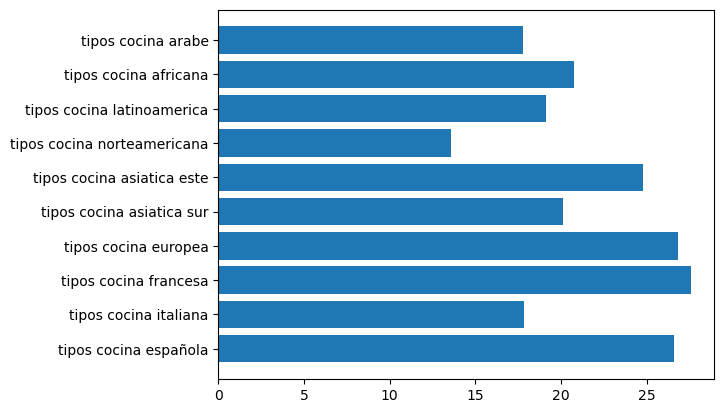

In [203]:
plt.barh(y = list(dic_promedios.keys()), width = list(dic_promedios.values()))

In [204]:
dfm.columns

Index(['nombre', 'numero de opiniones', 'puntuacion sobre 5', 'ranking',
       'precio', 'tipos de cocina', 'dietas especiales', 'ubicaciones',
       'puntuaciones desglosadas', 'precio promedio', 'categoria precio',
       'tipos cocina española', 'tipos cocina italiana',
       'tipos cocina francesa', 'tipos cocina europea',
       'tipos cocina asiatica sur', 'tipos cocina asiatica este',
       'tipos cocina norteamericana', 'tipos cocina latinoamerica',
       'tipos cocina africana', 'tipos cocina arabe', 'Halal', 'Kosher',
       'Opciones sin gluten', 'Opciones veganas', 'Opciones vegetarianas',
       'Pésimo', 'Malo', 'Normal', 'Muy bueno', 'Excelente'],
      dtype='object')

## Cantidad de restaurantes según el distrito

In [553]:
dfm = pd.read_csv('datos_madrid_geodata_condistrito.csv')

C:\Users\alexb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\alexb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\alexb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


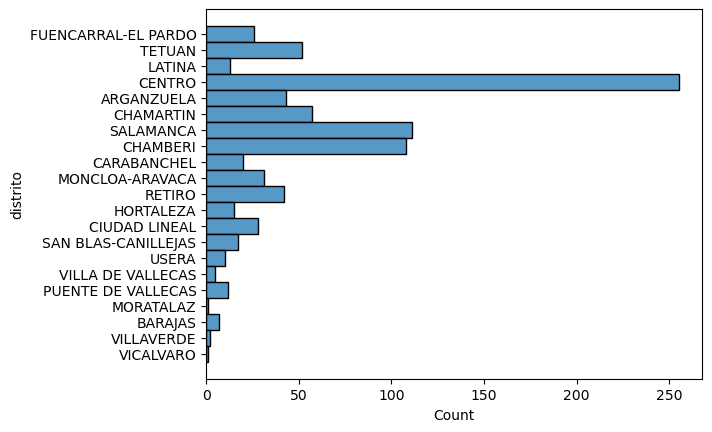

In [571]:
sns.histplot(data = dfm, y = 'distrito');

## Cantidad de restaurantes por barrio

Si acaso un cloropeth

In [574]:
dfm.columns

Index(['Unnamed: 0', 'nombre', 'numero de opiniones', 'puntuacion sobre 5',
       'ranking', 'precio', 'tipos de cocina', 'dietas especiales',
       'ubicaciones', 'puntuaciones desglosadas', 'precio promedio',
       'categoria precio', 'tipos cocina española', 'tipos cocina italiana',
       'tipos cocina francesa', 'tipos cocina europea',
       'tipos cocina asiatica sur', 'tipos cocina asiatica este',
       'tipos cocina norteamericana', 'tipos cocina latinoamerica',
       'tipos cocina africana', 'tipos cocina arabe', 'Halal', 'Kosher',
       'Opciones sin gluten', 'Opciones veganas', 'Opciones vegetarianas',
       'Pésimo', 'Malo', 'Normal', 'Muy bueno', 'Excelente', 'lat', 'long',
       'municipio', 'provincia', 'codigo postal',
       'direccion completa corregida', 'distrito', 'barrio'],
      dtype='object')

## 

## Cantidad de restaurantes según dietas especiales

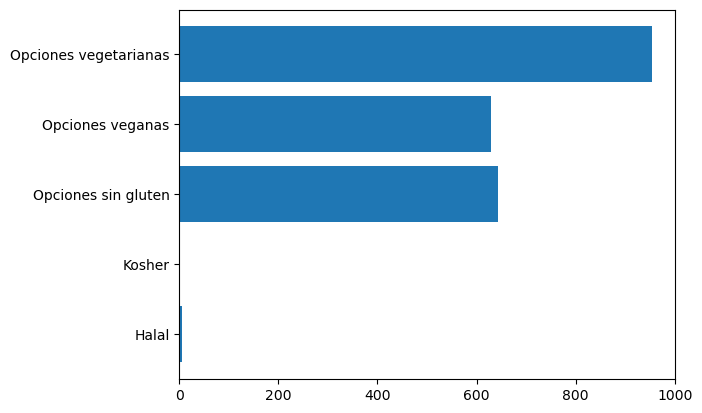

In [234]:
y = ['Halal', 'Kosher', 'Opciones sin gluten', 'Opciones veganas', 'Opciones vegetarianas']
width = []

for dieta in y:
    width.append(dfm[dieta].sum())
    
plt.barh(y = y, width = width);

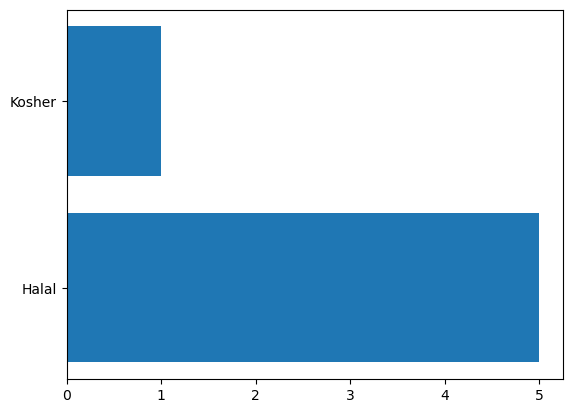

In [235]:
y = ['Halal', 'Kosher']
width = []

for dieta in y:
    width.append(dfm[dieta].sum())
    
plt.barh(y = y, width = width);

## Precio medio del restaurante por numero de opiniones

C:\Users\alexb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\alexb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


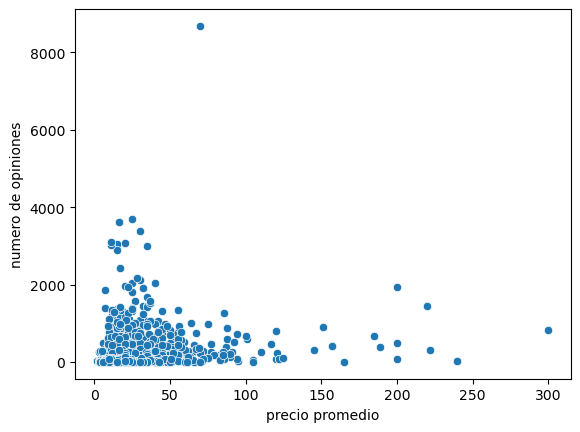

In [223]:
sns.scatterplot(data = dfm, x = 'precio promedio', y = 'numero de opiniones');

Observamos que no hay una relación aparente entre ambas variables: el número de opiniones no crece según lo hace el precio o viceversa. La mayoría de restaurantes tiene un precio promedio entre 0 y 50, así que vamos a hacer un nuevo scatter para ver más de cerca estos datos:

C:\Users\alexb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\alexb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


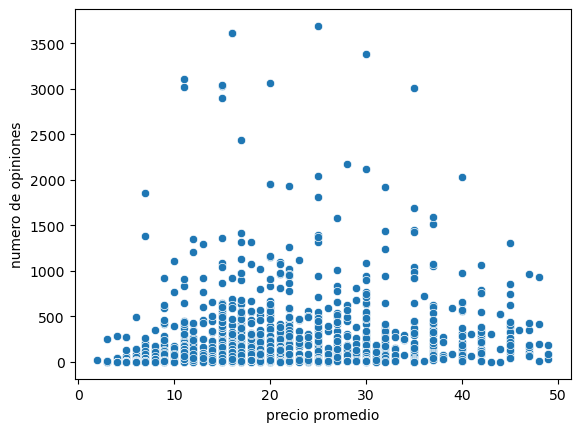

In [224]:
sns.scatterplot(data = dfm[dfm['precio promedio']<50], x = 'precio promedio', y = 'numero de opiniones');

De nuevo, no se intuye ninguna relación entre ambas variables.

## Ranking según el precio medio

C:\Users\alexb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\alexb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


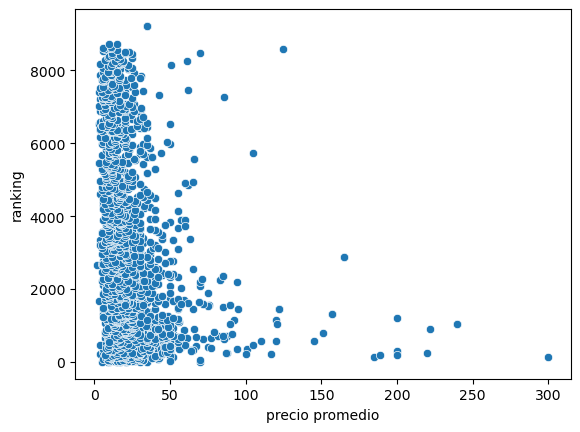

In [231]:
sns.scatterplot(data = dfm, x = 'precio promedio', y = 'ranking');

## Mediana de los ranking segun el tipo de cocina

Nota: esto no es muy interesante porque el numero que haya de cada uno tambien afecta

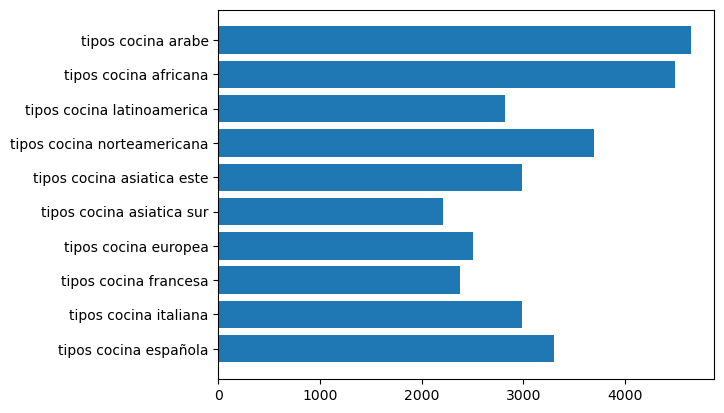

In [233]:
y = list(categorias_cocina.keys())
width = []
for cat in categorias_cocina:
    width.append(dfm.loc[dfm[cat], 'ranking'].median())
    
plt.barh(y = y, width = width);

## 

## Cantidad de restaurantes por tipo de cocina

<BarContainer object of 10 artists>

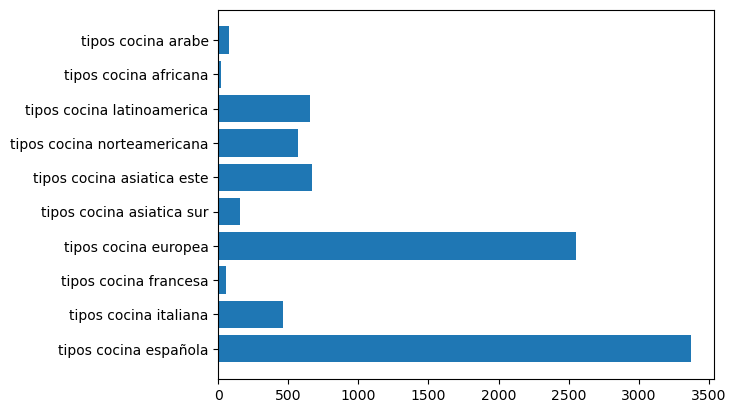

In [218]:
y = list(categorias_cocina.keys())
width = []
for cat in categorias_cocina:
    width.append(dfm[cat].sum())
    
plt.barh(y = y, width = width);

## Promedio de puntuaciones por tipo de cocina

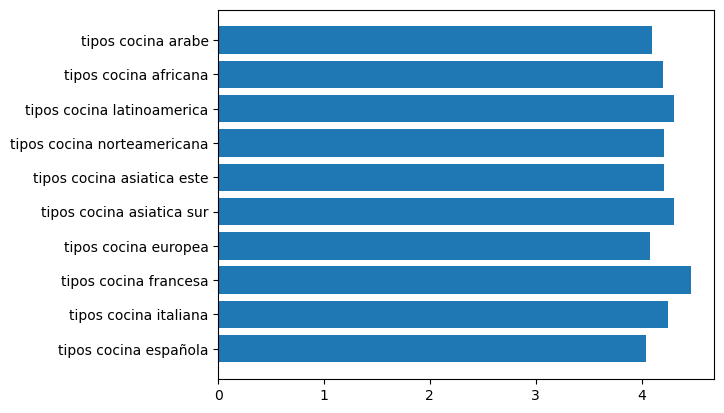

In [222]:
y = list(categorias_cocina.keys())
width = []
for cat in categorias_cocina:
    width.append(dfm.loc[dfm[cat], 'puntuacion sobre 5'].mean())
    
plt.barh(y = y, width = width);

## 

## Lectura  de JSON de Galicia y de España

In [2]:
import json

In [3]:
#Importante abrir el .json con formato UTF-8
world_geo_espanha = 'Data/Municipios_IGN.json'
with open(world_geo_espanha, encoding="utf-8") as json_file:
    json_data_espanha = json.load(json_file)

world_geo_madrid = 'Data/madrid-districts.json'
with open(world_geo_madrid, encoding="utf-8") as json_file:
    json_data_madrid = json.load(json_file)

In [4]:
for elemento in json_data_madrid['features']:
    elemento['properties']['name'] = elemento['properties']['name'].upper()
    if 'SAN BLAS' in elemento['properties']['name']:
        elemento['properties']['name'] = ''+elemento['properties']['name']+'-CANILLEJAS'

In [5]:
#Definimos una función que nos devuelva un DataFrame que usaremos para mostrar los promedios de las puntuaciones por cada municipio

def promedio_puntuacion_municipio(data_frame):
    df_puntuaciones = data_frame.groupby('municipio')['puntuaciones desglosadas'].sum().to_frame().reset_index()
    result = []
    for list_punt in df_puntuaciones['puntuaciones desglosadas'].values:
        list_float = [float(punt) for punt in list_punt]
        result.append(np.mean(list_float))
    df_puntuaciones['promedio puntuaciones'] = result
    return df_puntuaciones

In [6]:
#Definimos una función que nos devuelva un DataFrame que usaremos para mostrar los promedios de las puntuaciones por cada municipio

def promedio_puntuacion_distrito(data_frame):
    df_puntuaciones = data_frame.groupby('distrito')['puntuaciones desglosadas'].sum().to_frame().reset_index()
    result = []
    for list_punt in df_puntuaciones['puntuaciones desglosadas'].values:
        list_float = [float(punt) for punt in list_punt]
        result.append(np.mean(list_float))
    df_puntuaciones['promedio puntuaciones'] = result
    return df_puntuaciones

In [14]:
df_distrito_promedio = promedio_puntuacion_distrito(dfm)

KeyError: 'distrito'

## Promedio de puntuaciones por distrito

In [8]:
import folium
from folium import plugins

In [11]:
dfm = pd.read_csv('datos_tripadvisor_madrid_limpio.csv')

In [12]:
#Mostramos los datos por municipio para que machee con nuestro GeoJson y el promedio de puntuaciones para el json de Madrid

world_map = folium.Map(location = [dfm['lat'].values[0], dfm['long'].values[0]], zoom_start = 7)

folium.Choropleth(geo_data = json_data_madrid,
                  data     = df_distrito_promedio,
                  bins = 250,
                  columns  = ["distrito", "promedio puntuaciones"],
                  key_on   = "feature.properties.name").add_to(world_map)

world_map

NameError: name 'df_madrid' is not defined

## Folium para ver los restaurantes de cada municipio y su información

In [15]:
# Inicializa el mapa ubicado en Madrid
sf_map = folium.Map(location = [dfm['lat'].values[0], dfm['long'].values[0]], zoom_start = 7)

# Inicializamos un MarkerCluster() para los incidentes en el DataFrame
incidents = plugins.MarkerCluster()

for idx, row in dfm.iterrows(): 
    
    lat = row['lat']
    lng = row['long']
    label = row['nombre']
    direccion = row['direccion completa corregida']
    
    incidents.add_child(folium.Marker(location = [lat, lng],
                                      icon = folium.Icon(icon = "fa-solid fa-utensils",
                                                         icon_color = "white",
                                                         color = "green",
                                                         prefix = "fa"),
                                      popup    = label,
                                      tootltip = direccion))


# Agrega incidentes al mapa
sf_map.add_child(incidents)

sf_map

ValueError: Location values cannot contain NaNs.

In [16]:
df_temporal_promedio = dfm.groupby('distrito')['puntuacion sobre 5'].mean().to_frame().reset_index()
df_temporal_promedio['promedio precio'] = dfm.groupby('distrito')['precio promedio'].mean().values
df_temporal_promedio['num opiniones'] = dfm.groupby('distrito')['precio promedio'].sum().values
df_temporal_promedio['mayor ranking'] = dfm.groupby('distrito')['ranking'].min().values

KeyError: 'distrito'

## Precio medio y puntuación sobre 5 por distrito

In [17]:
px.strip(data_frame = df_temporal_promedio,
         x          = "puntuacion sobre 5",
         y          = "promedio precio",
         color      = "distrito")

NameError: name 'px' is not defined

In [18]:
#Hemos sacado una lista de las franquicias más conocidas en España

franquicias_restauracion = [
    "100 Montaditos",
    "Vips",
    "Foster's Hollywood",
    "La Tagliatella",
    "Pans & Company",
    "Taco Bell",
    "KFC",
    "Burger King",
    "McDonald's",
    "Ginos",
    "Foster's Hollywood",
    "Farggi",
    "Rodilla",
    "Panaria",
    "TGB",
    "Goiko Grill"
]

## Mostramos la ubicación de los restaurantes en un folium

In [20]:
#Pintamos la ubicación de franquicias en un mapa para ver su ubicación y su nombre en Madrid

franquicias_map = folium.Map(location = [dfm['lat'].values[0], dfm['long'].values[0]], zoom_start = 7)
# Inicializamos un MarkerCluster() para los incidentes en el DataFrame
incidents = plugins.MarkerCluster()

for idx, row in dfm[dfm['nombre'].isin(franquicias_restauracion)].iterrows(): 
    
    lat = row['lat']
    lng = row['long']
    label = row['nombre']
    direccion = row['direccion completa corregida']
    
    incidents.add_child(folium.Marker(location = [lat, lng],
                                      icon = folium.Icon(icon = "fa-solid fa-utensils",
                                                         icon_color = "white",
                                                         color = "green",
                                                         prefix = "fa"),
                                      popup    = label,
                                      tootltip = direccion))


# Agrega incidentes al mapa
franquicias_map.add_child(incidents)

franquicias_map

In [22]:
#Conteo de las franquicias con diferente nombre
dfm[dfm['nombre'].isin(franquicias_restauracion)].groupby('nombre')['nombre'].count()

nombre
100 Montaditos         5
Burger King           11
Foster's Hollywood     2
Ginos                  8
Goiko Grill            1
KFC                    3
McDonald's             3
Panaria                3
Rodilla               20
Taco Bell              4
Name: nombre, dtype: int64

In [23]:
from geopy.distance import distance

In [27]:
franquicias = dfm[dfm['nombre'].isin(franquicias_restauracion)]['nombre'].unique()

In [30]:
#Visualización de franquicias en Madrid

results = []

incidents = plugins.MarkerCluster()

center = (dfm['lat'].values[0],dfm['long'].values[0])
m = folium.Map(location=center, zoom_start=10)

for franquicia in franquicias:
    df_temporal = dfm[dfm['nombre']==franquicia]
    center = (df_temporal['lat'].values[0],df_temporal['long'].values[0])
    radius = 200

    folium.Circle(center, radius=radius, color='red', fill=True, fill_color='red').add_to(m)


    for idx, row in df_temporal.iterrows():

        lat = float(row['lat'])
        lng = float(row['long'])
        label = row['nombre']

        dist = distance(center, (lat, lng)).m

        if  dist <= radius:
            results.append(dist)
        print(results)
        
        
        incidents.add_child(folium.Marker(location = [lat, lng],
                                          icon = folium.Icon(icon = "fa-solid fa-utensils",
                                                             icon_color = "white",
                                                             color = "green",
                                                             prefix = "fa"),
                                          popup    = label))

    m.add_child(incidents)
    
m

[0.0]
[0.0]
[0.0]
[0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [31]:
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

In [32]:
def distancia_centro_madrid(localizacion):
    localizacion_centro = [40.41831, -3.70275]
    distancia_centro = geodesic((localizacion_centro[0], localizacion_centro[1]), (float(localizacion[0]), float(localizacion[1])))
    return distancia_centro.km

In [33]:
dfm['localizacion'] = {i: (dfm['lat'].values[i],dfm['long'].values[i]) for i in range(len(dfm['lat'].values))}

In [34]:
dfm['distancia al centro'] = dfm['localizacion'].apply(distancia_centro_madrid)

ValueError: Point coordinates must be finite. (nan, nan, 0.0) has been passed as coordinates.

In [39]:
#Precio promedio por distrito dependiendo de la distancia al centro

px.scatter(data_frame  = dfm,
           x           = "distancia al centro",
           y    = "precio promedio",
           color = "distrito",
           opacity     = 0.5)

NameError: name 'px' is not defined

In [40]:
#Precio promedio por distrito

px.box(data_frame = dfm,
       x          = "distrito",
       y          = "precio promedio",
       hover_name = "nombre")

NameError: name 'px' is not defined

In [41]:
#Precio promedio por barrio

px.box(data_frame = dfm,
       x          = "barrio",
       y          = "precio promedio",
       hover_name = "nombre")

NameError: name 'px' is not defined

KeyError: 'barrio'

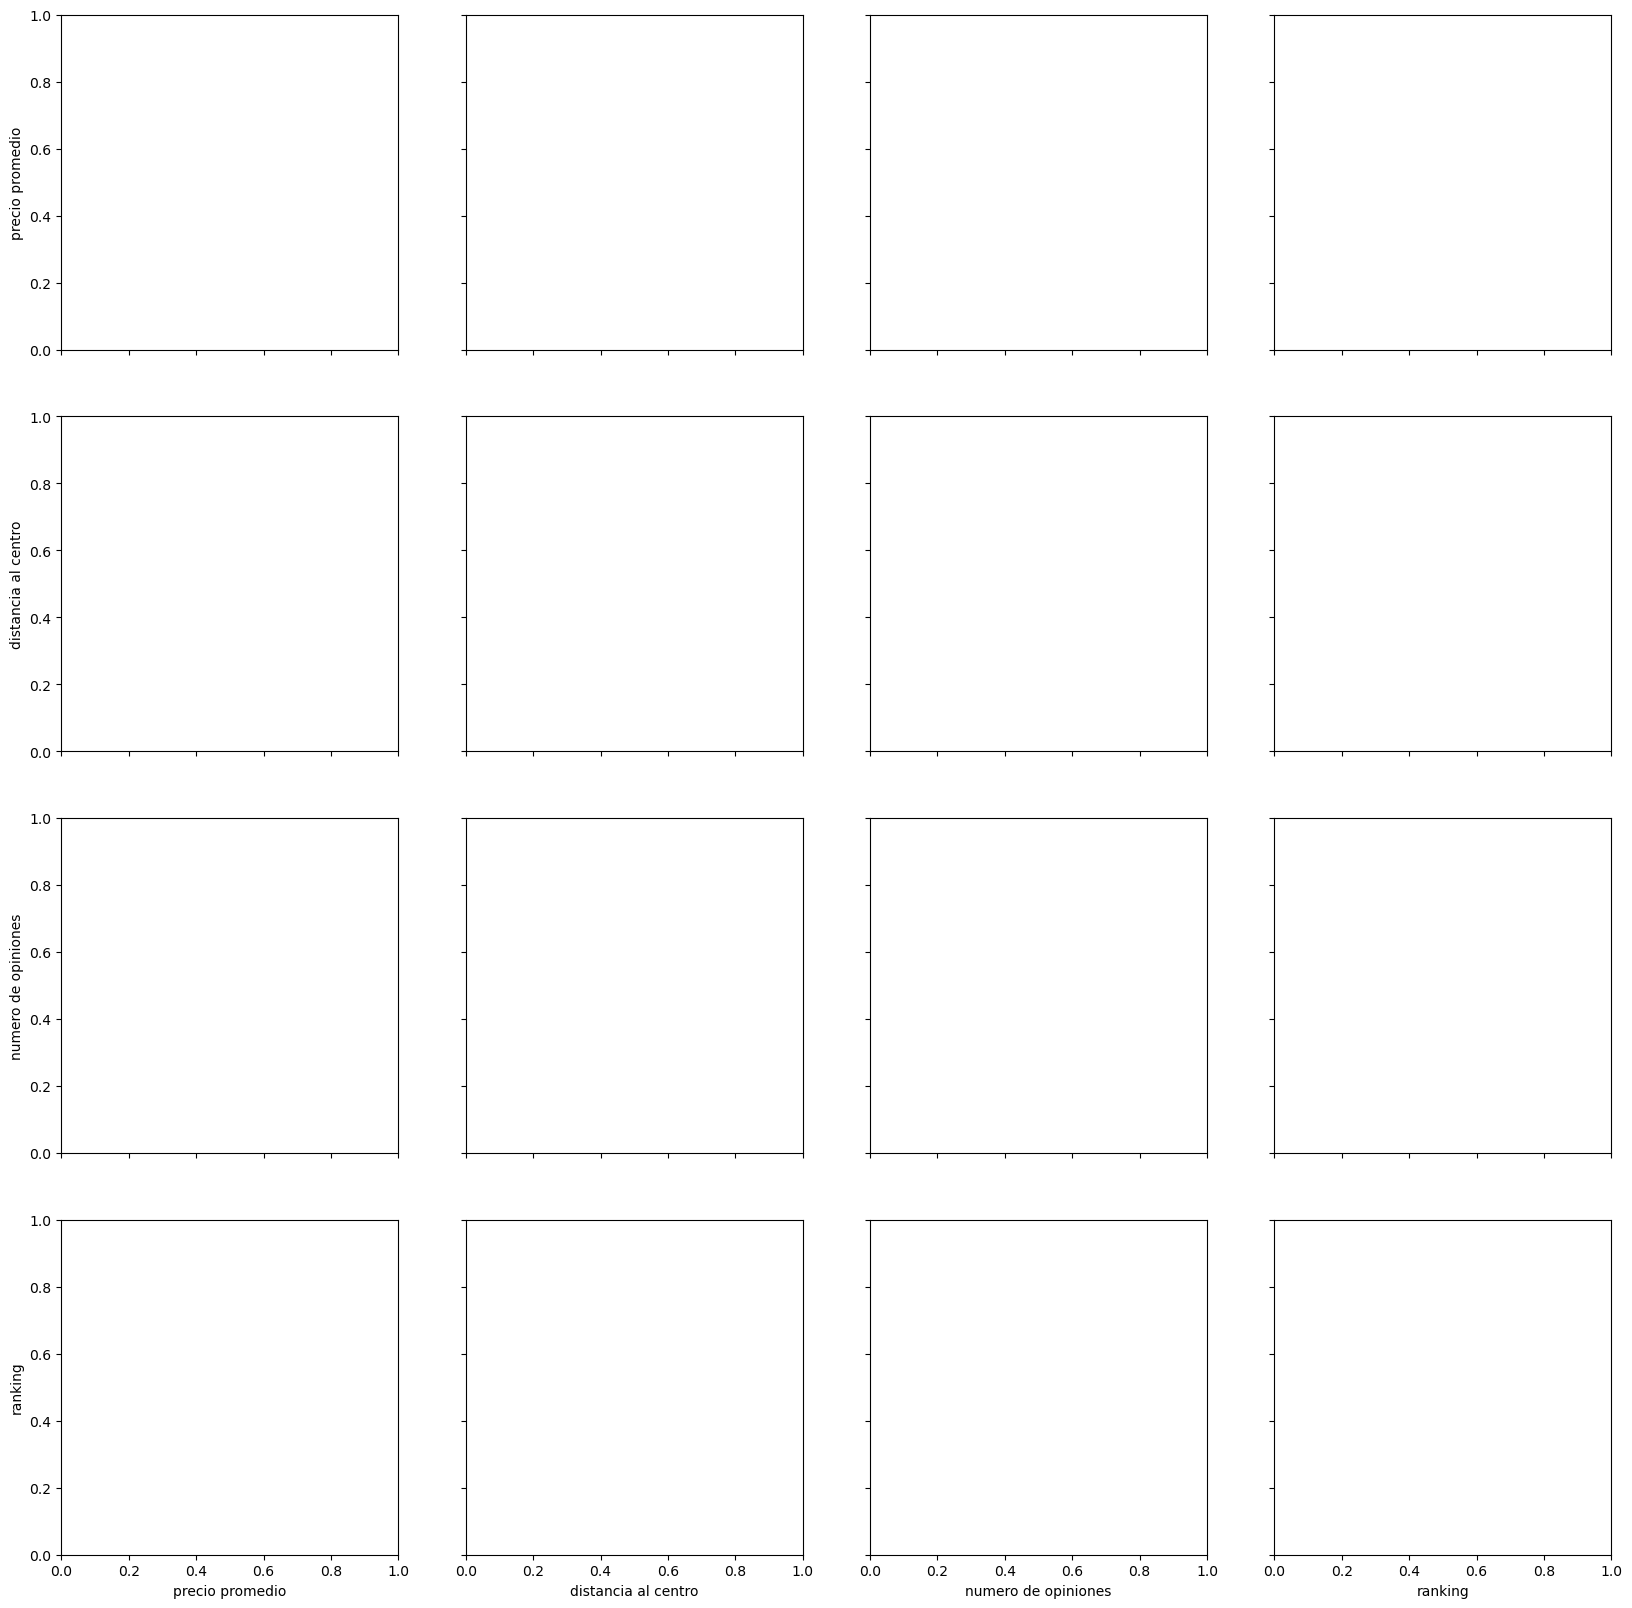

In [42]:
#Comparación de las columnas 'precio promedio', 'distancia al centro', 'numero de opiniones', 'ranking'

sns.pairplot(dfm, vars = ["precio promedio", "distancia al centro","numero de opiniones","ranking"], height = 5, hue = "barrio")
plt.show()

## Folium para ver los restaurantes de cada municipio y su información

# Basura

In [119]:
df = pd.read_csv('datos_tripadvisor_juntos_madrid_limpio.csv')
df2 = pd.read_csv('datos_tripadvisor_juntos_madrid.csv')

In [116]:
df2['numero de opiniones']

0       215
1       184
2       184
3       994
4       226
       ... 
7771     15
7772      8
7773      3
7774      9
7775      4
Name: numero de opiniones, Length: 7776, dtype: object

In [117]:
df['numero de opiniones']

0       190.0
1       166.0
2       184.0
3       925.0
4       218.0
        ...  
6302     76.0
6303      8.0
6304      3.0
6305      9.0
6306      4.0
Name: numero de opiniones, Length: 6307, dtype: float64

In [118]:
mask_no_nan = ~df['ranking'].isna()
mask_no_int = ~df.loc[:, 'ranking'].str[0].isin(numeros_str)
df.loc[mask_no_nan & mask_no_int, 'ranking'] = df.loc[mask_no_nan & mask_no_int, 'ranking'].str.split().str[1]
df.loc[mask_no_nan & ~mask_no_int, 'ranking'] = df.loc[mask_no_nan & ~mask_no_int, 'ranking'].str.replace('.','').astype(int)

AttributeError: Can only use .str accessor with string values!

In [ ]:
API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')
BASE_URL = 'https://maps.googleapis.com/maps/api/geocode/json'
params = {'address': 'Avda Europa 93 La Hacienda De Machado, 36212 Vigo España',
              'key': API_KEY}
respuesta = requests.get(BASE_URL, params=params)
datos = respuesta.json()
pprint(datos)

In [ ]:
soup = BeautifulSoup(browser.page_source, 'html.parser')

In [8]:
nombres = [x.text for x in soup.find_all('div', class_ = 'result-title')]

In [23]:
titulos = soup.find_all('div', class_ = 'result-title')
nombres = [x.text for x in titulos]
urls = ['https://www.tripadvisor.es'+ x['onclick'].split()[3].strip("',") for x in titulos]

In [9]:
soup_reviews = soup.find_all('div', class_ = 'rating-review-count')
cantidad_burbujas = [x.find('span')['alt'] for x in soup_reviews]
cantidad_opiniones = [x.text for x in soup_reviews]

In [10]:
direcciones = [x.text for x in soup.find_all('div', class_ = 'address-text')]

In [26]:
df = pd.DataFrame([nombres, cantidad_burbujas, cantidad_opiniones, direcciones, urls], ['nombre', 'burbujas', 'opiniones', 'direccion', 'url']).T

In [15]:
data = [nombres, num_opiniones, puntuacion_sobre5, ranking, precios, tipos_cocina, dietas_especiales, ubicaciones, puntuaciones_desglosadas] 
columnas = ['nombre', 'numero de opiniones', 'puntuacion sobre 5', 'ranking', 'precio', 'tipos de cocina', 'dietas especiales', 'ubicaciones', 'puntuaciones desglosadas']
df = pd.DataFrame(data, columnas).T
df

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas
0,Los Montes de Galicia,11.361,"5,0",1,"[50, 90]","[Española,, Internacional,, Mediterránea,, Sal...","[Opciones veganas, Opciones sin gluten]","Calle Azcona 46, 28028 Madrid España","[7, 28, 175, 1.082, 7.394]"
1,Trattoria Pulcinella,2766,"4,5",15,"[11, 29]","[Italiana,, Napolitana,, De, Campania,, Romana...","[Opciones vegetarianas, Opciones veganas, Op...","C/ de Regueros, 7, 28004 Madrid España","[34, 39, 104, 320, 1.620]"
2,GastroVía 61,2018,"4,5",176,"[30, 45]","[Mediterránea,, Europea,, Española,, Saludable]","[Opciones vegetarianas, Opciones sin gluten]","Calle Flor Baja, 3 Hotel Mayorazgo, 28013 Madr...","[8, 13, 45, 155, 1.296]"
3,Chocolatería San Ginés,23.394,"4,0",.º 9,"[2, 6]","[Café,, Española]",[Abierto hasta tarde],"Pasadizo de San Ginés 5, 28013 Madrid España","[479, 603, 1.840, 4.195, 6.252]"


In [111]:
for idx, tipo_rating in enumerate(tipos_rating):
            lista_temp.append(soup.find('div', {'data-value': f'{idx+1}'}).text.strip('tipo_rating'))
        puntuaciones_desglosadas.append(lista_temp)

'Bar La Campana'

In [10]:
soup.find('div', {'data-value': '5'}).text

'Excelente7.394'

In [95]:
soup.find('h1', 'HjBfq').text

'Los Montes de Galicia'

In [71]:
soup.find('b').text[1:]

'1'

In [91]:
tipos_rating = ['Excelente', 'Muy bueno', 'Normal', 'Malo', 'Pésimo']
tipos_rating = tipos_rating[::-1]

In [92]:
tipos_rating

['Pésimo', 'Malo', 'Normal', 'Muy bueno', 'Excelente']

In [14]:
def guardar_csv(data, columnas, csv_name):
    with open(csv_name, mode='a', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(columnas)
        for i in range(len(data[0])):
            row = [field_list[i] for field_list in data]
            writer.writerow(row)
        csvfile.close()

In [15]:
guardar_csv(data, columnas, 'datos_tripadvisor3.csv')

In [13]:
data = [nombres, num_opiniones, puntuacion_sobre5, ranking, precios, tipos_cocina, dietas_especiales, ubicaciones, puntuaciones_desglosadas]


In [8]:
dates = pd.date_range('1/1/2000', periods=8)

df = pd.DataFrame(np.random.randn(8, 4), index=dates, columns=['A', 'B', 'C', 'D'])
df

,A,B,C,D
2000-01-01,-0.931521,1.880524,0.713367,-1.778306
2000-01-02,-0.208930,0.490122,-1.985775,-0.274736
2000-01-03,-1.115234,2.831690,-1.285558,-0.240756
2000-01-04,1.700493,0.455873,-0.265777,-0.046853
2000-01-05,-0.190865,0.841611,0.476878,-0.814052
2000-01-06,-0.265555,-0.192821,-0.786812,0.689169
2000-01-07,-0.177948,-0.312821,-0.858496,-0.242251
2000-01-08,-1.206327,0.996272,0.590540,0.147295


In [20]:
df.iloc[:, [0,1]] = df[['B', 'A']]

In [14]:
df[['B', 'A']].to_numpy()

array([[ 1.88052409, -0.931521  ],
       [ 0.49012179, -0.20893041],
       [ 2.83169031, -1.11523362],
       [ 0.45587327,  1.70049281],
       [ 0.84161129, -0.19086477],
       [-0.19282144, -0.26555538],
       [-0.31282088, -0.17794785],
       [ 0.99627248, -1.20632689]])

In [21]:
df

,A,B,C,D
2000-01-01,-0.931521,1.880524,0.713367,-1.778306
2000-01-02,-0.208930,0.490122,-1.985775,-0.274736
2000-01-03,-1.115234,2.831690,-1.285558,-0.240756
2000-01-04,1.700493,0.455873,-0.265777,-0.046853
2000-01-05,-0.190865,0.841611,0.476878,-0.814052
2000-01-06,-0.265555,-0.192821,-0.786812,0.689169
2000-01-07,-0.177948,-0.312821,-0.858496,-0.242251
2000-01-08,-1.206327,0.996272,0.590540,0.147295


In [3]:
df = pd.DataFrame({"A": [1, 2], "B": [3, 4]}, dtype=object)

df.dtypes

A    object
B    object
dtype: object

In [4]:
df.loc[:, 'A'] = (df.loc[:, 'A']).astype(int)

df.dtypes

A    object
B    object
dtype: object

In [2]:
pd.__version__

'2.1.2'

In [1]:
!pip install --upgrade "jupyterlab<4" jupyterlab-git

ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\alexb\\AppData\\Local\\Temp\\pip-uninstall-6ntiolkn\\jupyter-lab.exe'
Consider using the `--user` option or check the permissions.




  Obtaining dependency information for jupyterlab<4 from https://files.pythonhosted.org/packages/4e/f3/be0f5e5e0f4fee701aaa62ed44b3fe590d0af27d52bab7832ece9d81c727/jupyterlab-3.6.6-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-git from https://files.pythonhosted.org/packages/a1/99/0999cd50929d512241c0a0693cd9a0483a971551a2da466ee4d44b45543d/jupyterlab_git-0.44.0-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
     -- ------------------------------------- 0.4/5.3 MB 11.2 MB/s eta 0:00:01
     ----- ---------------------------------- 0.8/5.3 MB 8.1 MB/s eta 0:00:01
     -------- ------------------------------- 1.1/5.3 MB 7.9 MB/s eta 0:00:01
     ---------------- ----------------------- 2.1/5.3 MB 11.4 MB/s eta 0:00:01
     ----------------------------- ---------- 3.9/5.3 MB 16.8 MB/s eta 0:00:01
     ---------------------------------------  5.3/5.3 MB 19.8 MB/s eta 0:00:01
     ------------------------------